# 1. Remarks
1.  Split dataset int train & test sets

2.  Do 4-fold cross validation.
    - Split train set into training & validation sets by 4-fold (i.e., 3 training parts + 1 validation part)
    - Train the models
    - We obtain 4 different trained models 
    - Evaluate those 4 trained models using test set
    
    
3.  Because using 4-fold cross validation, we need to do the feature extraction separately for each fold

    The reason is that we must standardize / normalize the feature (for training & validation sets) before fitting into the model
    
4.  Step-by-step doing feature extraction for each fold 
    * From the training set, we do:
        - SIFT + bags of visual words (i.e., k-means clustering) 
        - Gabor 
        - HOG + PCA 
        - LBP histogram + PCA
    *  Standardize the features for training set
    *  Fit obtained standardization into validation set and also test set 


In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

In [2]:
from platform import python_version

print(python_version())

3.8.13


In [3]:
print(skimage.__version__)

0.19.2


# 2. Create training, validation & test sets for 4-fold cross validation

## 2.1. Load dataset (from the previous works which uses the manual train-validation-test splitting )

In [4]:
filepath_train = "..//_inputs//_images_Zooscan//ZooScan-train_img.csv"
print(filepath_train)

filepath_validation = "..//_inputs//_images_Zooscan//ZooScan-validation_img.csv"
print(filepath_validation)

filepath_test = "..//_inputs//_images_Zooscan//ZooScan-test_img.csv"
print(filepath_test)

X_train_df = pd.read_csv(filepath_train)
X_validation_df = pd.read_csv(filepath_validation)
X_test_df = pd.read_csv(filepath_test)

display(X_train_df.head(5), X_train_df.shape)
display(X_validation_df.head(5), X_validation_df.shape)
display(X_test_df.head(5), X_test_df.shape)

..//_inputs//_images_Zooscan//ZooScan-train_img.csv
..//_inputs//_images_Zooscan//ZooScan-validation_img.csv
..//_inputs//_images_Zooscan//ZooScan-test_img.csv


,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_validation//agg...,aggregats_debris,0001.png,0
1,..//_inputs//_images_Zooscan//_validation//agg...,aggregats_debris,0002-aggregates_001.png,0
2,..//_inputs//_images_Zooscan//_validation//agg...,aggregats_debris,0003.png,0
3,..//_inputs//_images_Zooscan//_validation//agg...,aggregats_debris,0007-aggregates_001.png,0
4,..//_inputs//_images_Zooscan//_validation//agg...,aggregats_debris,0008-aggregates_001.png,0


(14700, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0007-aggregates_002.png,0
1,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0009-aggregates_001.png,0
2,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,0012-aggregates_002.png,0
3,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_001.png,0
4,..//_inputs//_images_Zooscan//_test//aggregats...,aggregats_debris,002-aggregates_007.png,0


(6907, 4)

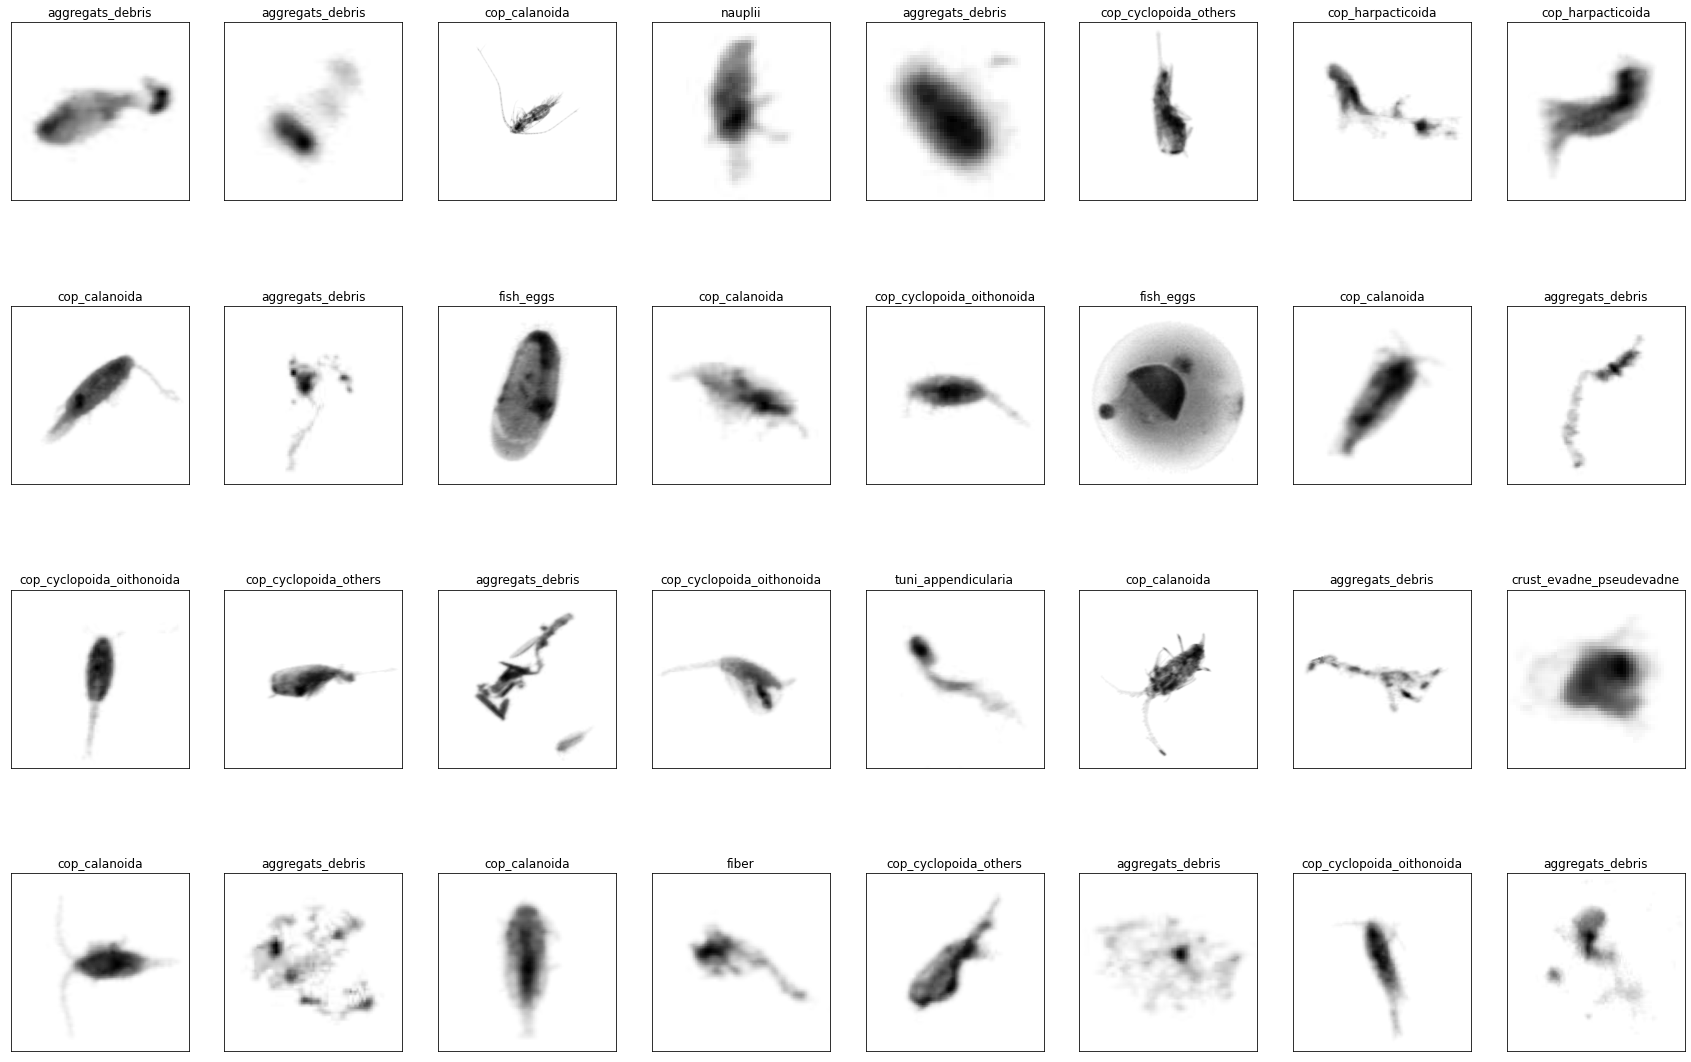

In [5]:
# display some images
plt.figure(figsize=(30,20))

for i in range(32):
    idx_img = random.randint(len(X_train_df))
    label = X_train_df["labels"][idx_img]
    img = io.imread(X_train_df["filenames"][idx_img])
    
    ax = plt.subplot(4,8,i+1)
    ax.set_title(label)
    plt.imshow(img, cmap="Greys_r")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    

## 2.2. Merge (old) train and validation sets for 4-fold cross validation

## 2.3. Make training and validation sets for 4 folds and save into files

### 2.3.1. Plot the class distribution on both training and validation sets of each fold

#### Some functions for visualization

In [6]:
# normal bar chart
def showDataDistribution(dfDataset, boolSorted = 0):
    dfDataset_classes = dfDataset.groupby('labels').size().to_frame('number of images').reset_index()
    dfDataset_classes_sorted = dfDataset_classes.sort_values(by=['number of images'], ascending=False)
    if boolSorted == 1:
        dfDataset_classes_sorted_occurency = dfDataset_classes_sorted['number of images'].tolist()
    else:
        dfDataset_classes_sorted_occurency = dfDataset_classes['number of images'].tolist()
    # display(class_occurrency_data_df)
    
    # plot the dataset to see data distribution
    ax = dfDataset_classes_sorted.plot.bar(x='labels', y='number of images',
                              figsize=(25,15), fontsize=20, 
                              ylim=[0,max(dfDataset_classes_sorted_occurency)*1.5])

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005-0.2, p.get_height() * 1.005+50), fontsize=15)

In [183]:
# Bidirectional bar charts
def displayBidirectionalCharts(dfDataset1, title1, dfDataset2, title2, titleFigure):
    dfDataset1_classes = dfDataset1.groupby('labels').size().to_frame('NumImages1').reset_index()
    dfDataset1_classes_sorted = dfDataset1_classes.sort_values(by=['NumImages1'], ascending=False)
    # dfDataset1_classes_sorted_occurencies = dfDataset1_classes_sorted['NumImages1'].tolist()

    dfDataset2_classes = dfDataset2.groupby('labels').size().to_frame('NumImages2').reset_index()
    dfDataset2_classes_sorted = dfDataset2_classes.sort_values(by=['NumImages2'], ascending=False)
    # dfDataset2_classes_sorted_occurencies = dfDataset2_classes_sorted['NumImages2'].tolist()
    
    dfDataset_merged = pd.merge(dfDataset1_classes_sorted, dfDataset2_classes_sorted, how='inner', on = 'labels')
    
    font_color = '#525252'
    hfont = {}
    facecolor = '#eaeaf2'
    color_red = '#fd625e'
    color_blue = '#01b8aa'
    index = dfDataset_merged.index
    yLabels = dfDataset_merged['labels']
    column0 = dfDataset_merged['NumImages1']
    column1 = dfDataset_merged['NumImages2']
    title0 = title1
    title1 = title2

    fig, axes = plt.subplots(figsize=(30,15), ncols=2, sharey=True, tight_layout=True)
    # fig.tight_layout()

    axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
    axes[0].set_title(title0, fontsize=20, pad=15, color=color_red, **hfont)
    
    axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
    axes[1].set_title(title1, fontsize=20, pad=15, color=color_blue, **hfont)
    
    axes[0].set_xlim([0, 17000])
    axes[1].set_xlim([0, 6000])
    # If you have positive numbers and want to invert the x-axis of the left plot
    axes[0].invert_xaxis() 

    # To show data from highest to lowest
    plt.gca().invert_yaxis()

    axes[0].set(yticks=index, yticklabels=yLabels)
    axes[0].yaxis.tick_left()
    axes[0].tick_params(axis='y', colors='white') # tick color

    for i, v in enumerate(column0):
        axes[0].text(v+1200, index[i],
             str(round(v, 2)),
             fontsize = 15, fontweight ='bold',
             color ='black')
    
    for i, v in enumerate(column1):
        axes[1].text(v+200, index[i],
                 str(round(v, 2)),
                 fontsize = 15, fontweight ='bold',
                 color ='black')
    
    for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
        label.set(fontsize=20, color=font_color, **hfont)
    for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
        label.set(fontsize=20, color=font_color, **hfont)
    
    for ax in axes:
        for tick in ax.xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)

    
    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)
    
    
    st = plt.suptitle(titleFigure, fontsize = 25, fontweight ='bold', color='b', **hfont)
    st.set_x(0.55)
    
    plt.subplots_adjust(wspace=0.1, top=0.85, bottom=0.1, left=0.18, right=0.95)
    
    plt.show()

In [236]:
# Grouped bar chart
def displayGroupedBarChartsVertically(dfDataset1, title1, dfDataset2, title2, titleFigure):
    dfDataset1_classes = dfDataset1.groupby('labels').size().to_frame('NumImages1').reset_index()
    dfDataset1_classes_sorted = dfDataset1_classes.sort_values(by=['NumImages1'], ascending=False)
    # dfDataset1_classes_sorted_occurencies = dfDataset1_classes_sorted['NumImages1'].tolist()

    dfDataset2_classes = dfDataset2.groupby('labels').size().to_frame('NumImages2').reset_index()
    dfDataset2_classes_sorted = dfDataset2_classes.sort_values(by=['NumImages2'], ascending=False)
    # dfDataset2_classes_sorted_occurencies = dfDataset2_classes_sorted['NumImages2'].tolist()
    
    dfDataset_merged = pd.merge(dfDataset1_classes_sorted, dfDataset2_classes_sorted, how='inner', on = 'labels')
    
    font_color = '#525252'
    hfont = {}
    facecolor = '#eaeaf2'
    color_red = '#fd625e'
    color_blue = '#01b8aa'
    index = dfDataset_merged.index
    yLabels = dfDataset_merged['labels']
    column0 = dfDataset_merged['NumImages1']
    column1 = dfDataset_merged['NumImages2']
    title0 = title1
    title1 = title2

    # lang = dfDataset_merged['labels']
    # use = dfDataset_merged['number of images train']
    # use2 = dfDataset_merged['number of images validation']


    width=2
    ind = np.arange(len(yLabels))*width*3 + 5

    # Figure Size
    fig, ax = plt.subplots(figsize =(10, 20), tight_layout=True)
    plt.gca().invert_yaxis() 
    ax.barh(ind-width/2, column0, width, align='center', alpha=0.7, color='r', label=title0) 
    ax.barh(ind+width/2, column1, width, align='center', alpha=0.7, color='b', label=title1) 
    
    ax.set(yticks=ind, yticklabels=yLabels, xlim=[0,18000])
    
    ax.margins(0.03)
    ax.grid(True)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)


    plt.xlabel('Number of images', fontsize = 20)
    plt.title(titleFigure, fontsize = 25)
    plt.legend(loc='lower right', fontsize = 20)



    for i, v in enumerate(column0):
        ax.text(v+100, ind[i]-0.5,
                 str(round(v, 2)),
                 fontsize = 15, fontweight ='bold',
                 color ='red')

    for i, v in enumerate(column1):
        ax.text(v+300, ind[i]+1.75,
                 str(round(v, 2)),
                 fontsize = 15, fontweight ='bold',
                 color ='blue')


    for ylabel in ax.get_yticklabels():
        ylabel.set_fontsize(20)
    for xlabel in ax.get_xticklabels():
        xlabel.set_fontsize(20)

    plt.show()

In [237]:
def displayGroupedBarChartsHorizontally(dfDataset1, title1, dfDataset2, title2, titleFigure):
    dfDataset1_classes = dfDataset1.groupby('labels').size().to_frame('NumImages1').reset_index()
    dfDataset1_classes_sorted = dfDataset1_classes.sort_values(by=['NumImages1'], ascending=False)
    # dfDataset1_classes_sorted_occurencies = dfDataset1_classes_sorted['NumImages1'].tolist()

    dfDataset2_classes = dfDataset2.groupby('labels').size().to_frame('NumImages2').reset_index()
    dfDataset2_classes_sorted = dfDataset2_classes.sort_values(by=['NumImages2'], ascending=False)
    # dfDataset2_classes_sorted_occurencies = dfDataset2_classes_sorted['NumImages2'].tolist()
    
    dfDataset_merged = pd.merge(dfDataset1_classes_sorted, dfDataset2_classes_sorted, how='inner', on = 'labels')
    
    font_color = '#525252'
    hfont = {}
    facecolor = '#eaeaf2'
    color_red = '#fd625e'
    color_blue = '#01b8aa'
    index = dfDataset_merged.index
    yLabels = dfDataset_merged['labels']
    column0 = dfDataset_merged['NumImages1']
    column1 = dfDataset_merged['NumImages2']
    title0 = title1
    title1 = title2

    width=2
    ind = np.arange(len(yLabels))*width*3 + 5

    fig, ax = plt.subplots(figsize =(20, 10),tight_layout=True)

    ax.bar(ind-width/2, column0, width, align='center', alpha=0.7, color='r', label=title0) 
    ax.bar(ind+width/2, column1, width, align='center', alpha=0.7, color='b', label=title1)

    for xlabel in ax.get_xticklabels():
        xlabel.set_ha("right")
        xlabel.set_rotation(45)
        xlabel.set_fontsize(25)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Images', fontsize = 25)
    ax.set_title(titleFigure, fontsize = 25)
    ax.set_xticks(ind, yLabels)
    ax.legend(loc='upper right', fontsize = 15)
    ax.set_ylim(0, 16000)
    ax.margins(0.03)
    ax.grid(True)

    for ylabel in ax.get_yticklabels():
        ylabel.set_fontsize(20)
    for xlabel in ax.get_xticklabels():
        xlabel.set_fontsize(20)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
        
    for i, v in enumerate(column0):
        ax.text(ind[i]-4, v+100,
                 str(round(v, 2)),
                 fontsize = 15, fontweight ='bold',
                 color ='red')

    for i, v in enumerate(column1):
        ax.text(ind[i]-2, v+5000,
                 str(round(v, 2)),
                 fontsize = 15, fontweight ='bold',
                 color ='blue')

    plt.show()

In [241]:
from fnmatch import fnmatch

In [242]:
all_CSV = []

for path, subdirs, files in os.walk('..//_inputs//_images_Zooscan//'):
    for name in files:
        if fnmatch(name, '*.csv'):
            all_CSV.append(os.path.join(path, name))

In [243]:
all_CSV

['..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-validation-fold_3.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv',
 '..//_inputs//_images_Zooscan//ZooScan-test_img.csv',
 '..//_inputs//_images_Zooscan//ZooScan-train_img.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv',
 '..//_inputs//_images_Zooscan//ZooScan-validation_img.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-validation-fold_4.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-training-fold_3.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv',
 '..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv']

#### 2.3.1.1. Fold 1

In [247]:
# 1st fold
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

display(dfFoldTraining_1.head(5), dfFoldTraining_1.shape)
display(dfFoldValidation_1.head(5), dfFoldValidation_1.shape)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates-jo_700_05.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0010-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0011.png,0


(14700, 4)

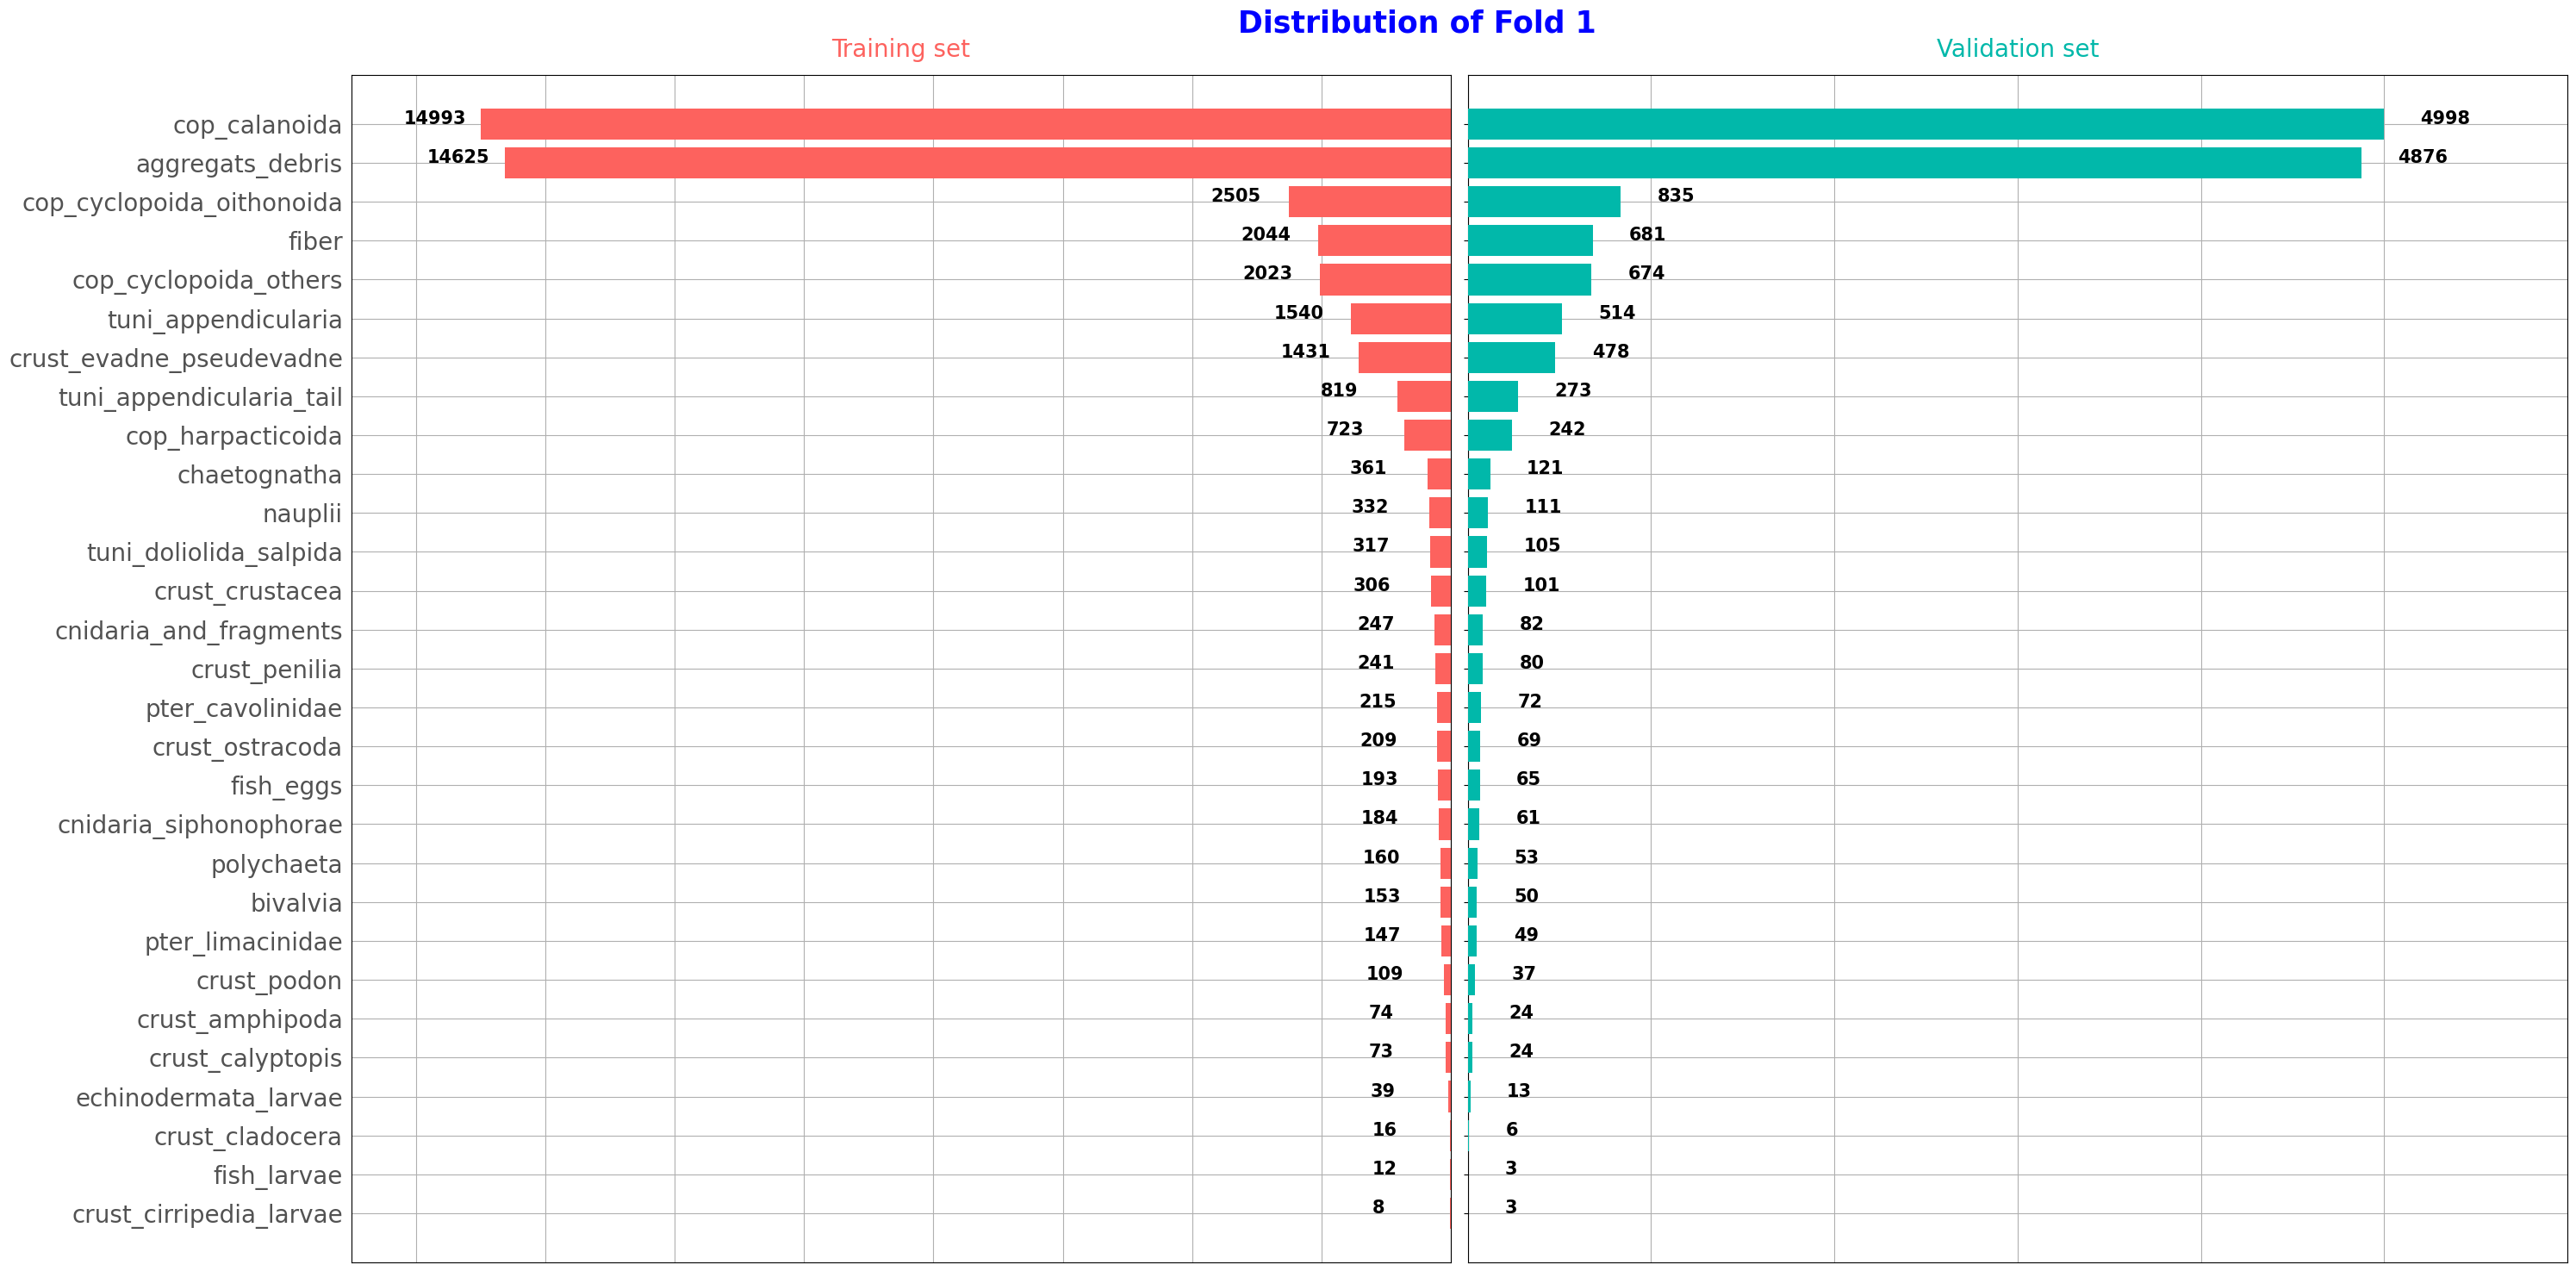

In [256]:
displayBidirectionalCharts(dfFoldTraining_1, 'Training set', dfFoldValidation_1, 'Validation set', 'Distribution of Fold 1')

#### 2.3.1.2. Fold 2

In [248]:
# 1st fold
dfFoldTraining_2 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv')
dfFoldValidation_2 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv')

display(dfFoldTraining_2.head(5), dfFoldTraining_2.shape)
display(dfFoldValidation_2.head(5), dfFoldValidation_2.shape)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0005-aggregates.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0008-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates_003.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates_006.png,0


(14700, 4)

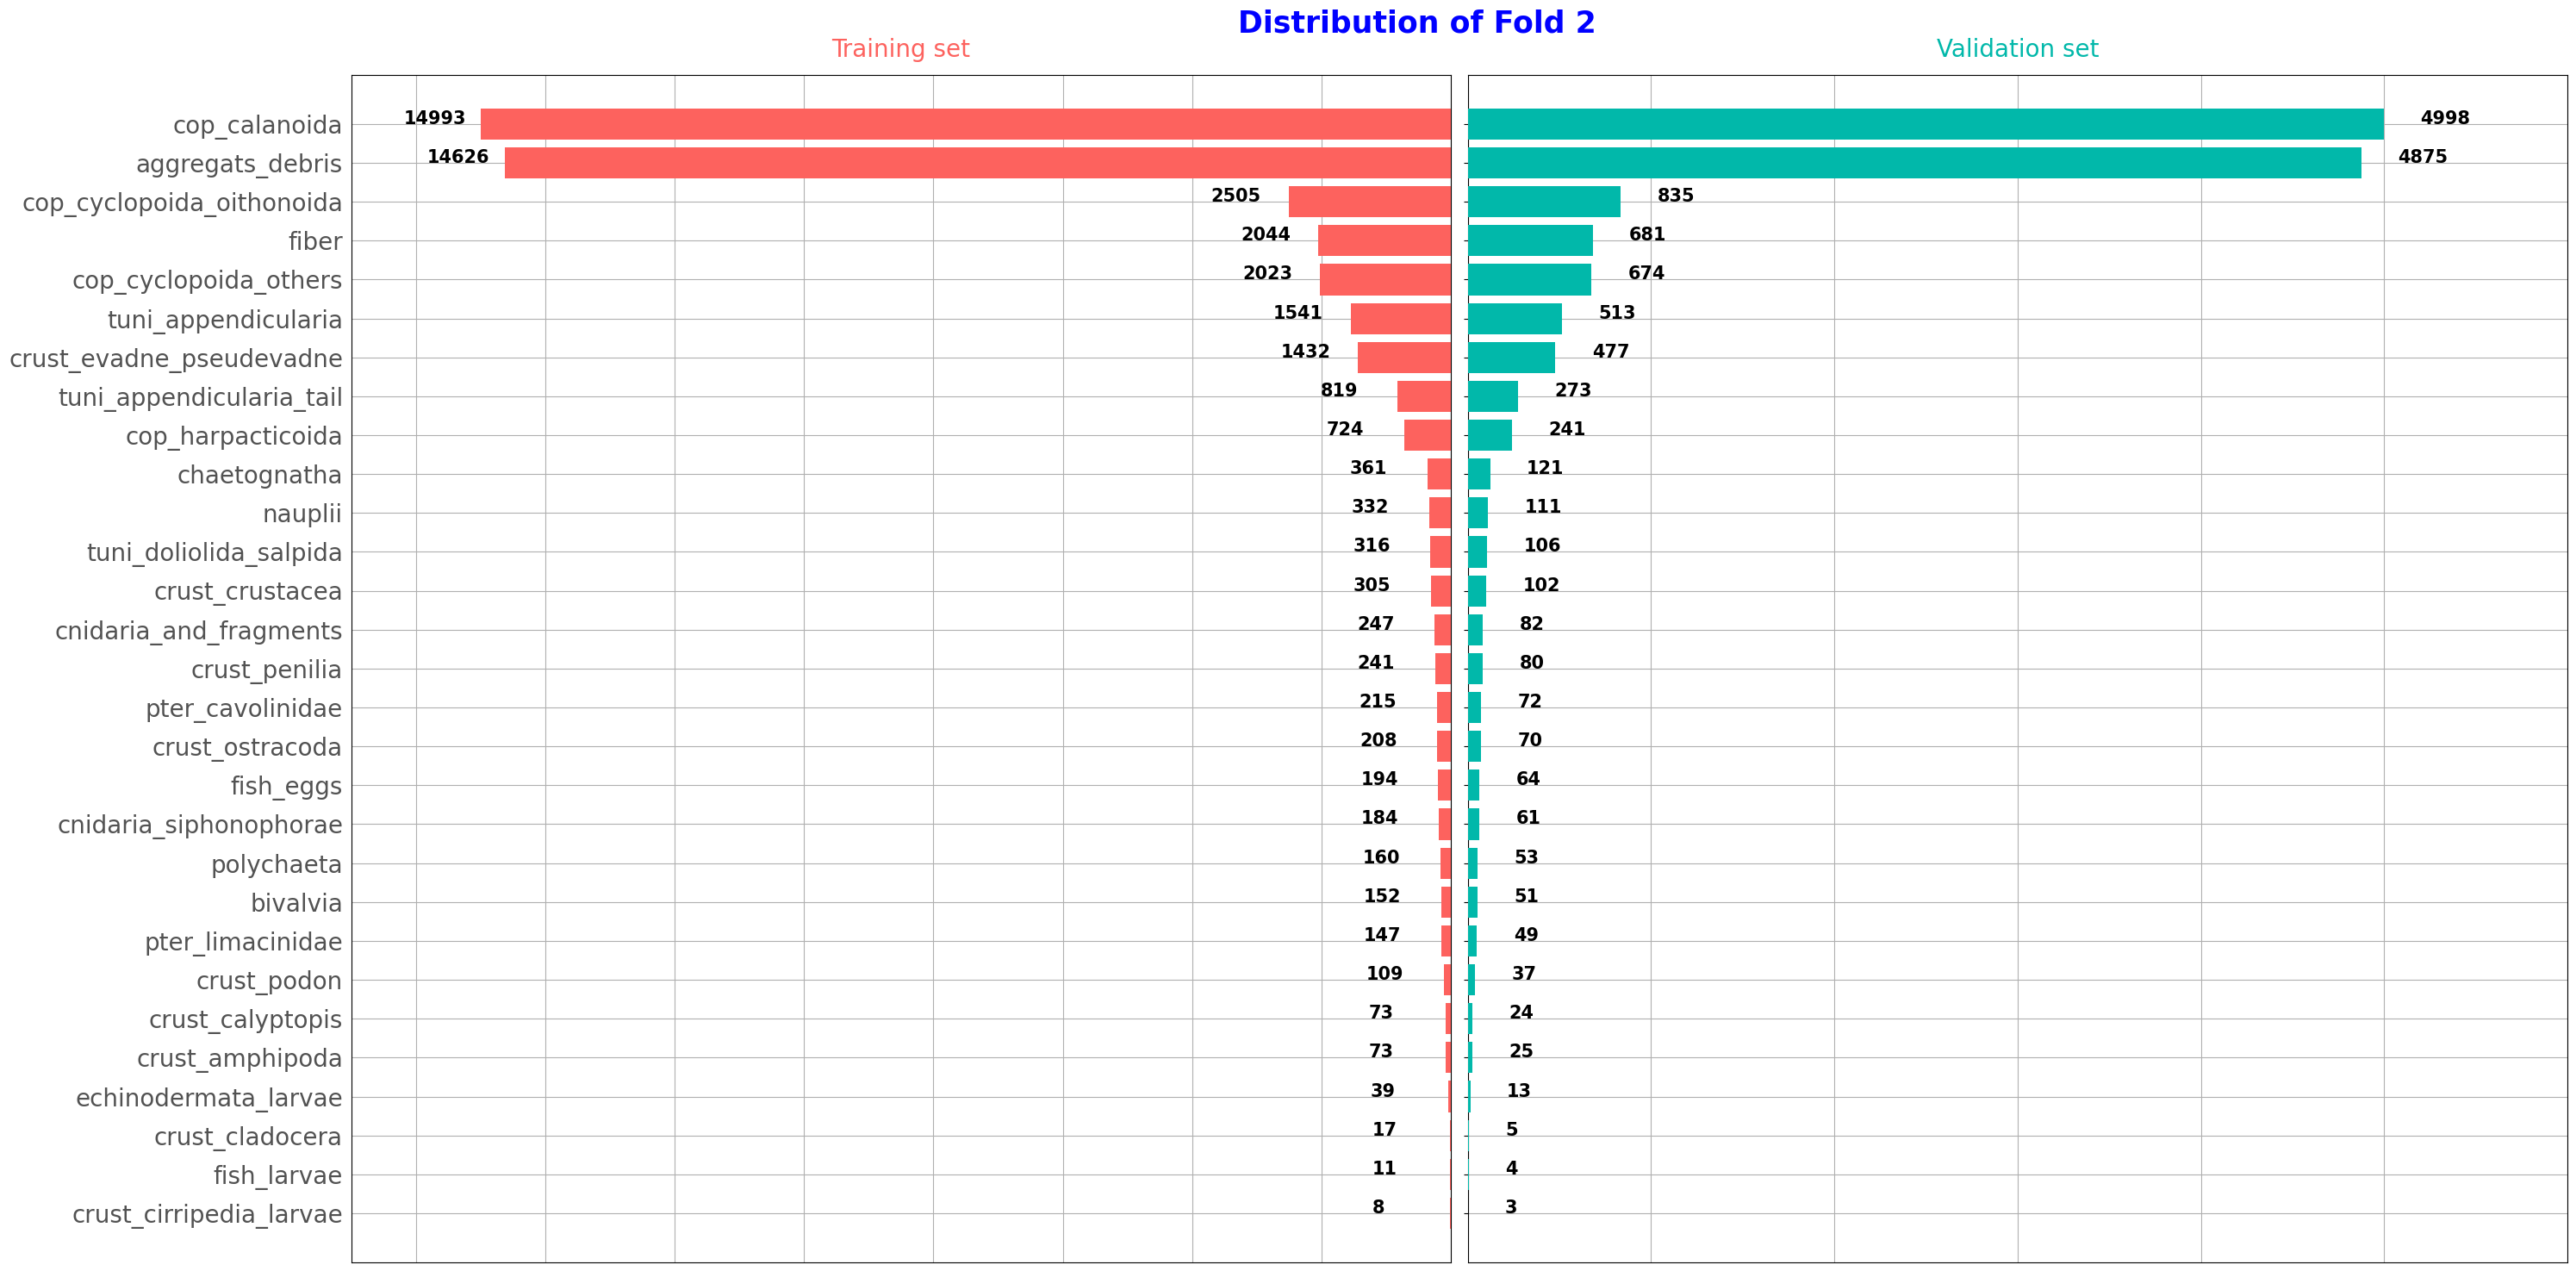

In [249]:
displayBidirectionalCharts(dfFoldTraining_2, 'Training set', dfFoldValidation_2, 'Validation set', 'Distribution of Fold 2')

#### 2.3.1.3. Fold 3

In [250]:
# 1st fold
dfFoldTraining_3 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_3.csv')
dfFoldValidation_3 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_3.csv')

display(dfFoldTraining_3.head(5), dfFoldTraining_3.shape)
display(dfFoldValidation_3.head(5), dfFoldValidation_3.shape)


,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0


(44099, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0005-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates_001.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0009.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,001-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0012-aggregates_001.png,0


(14700, 4)

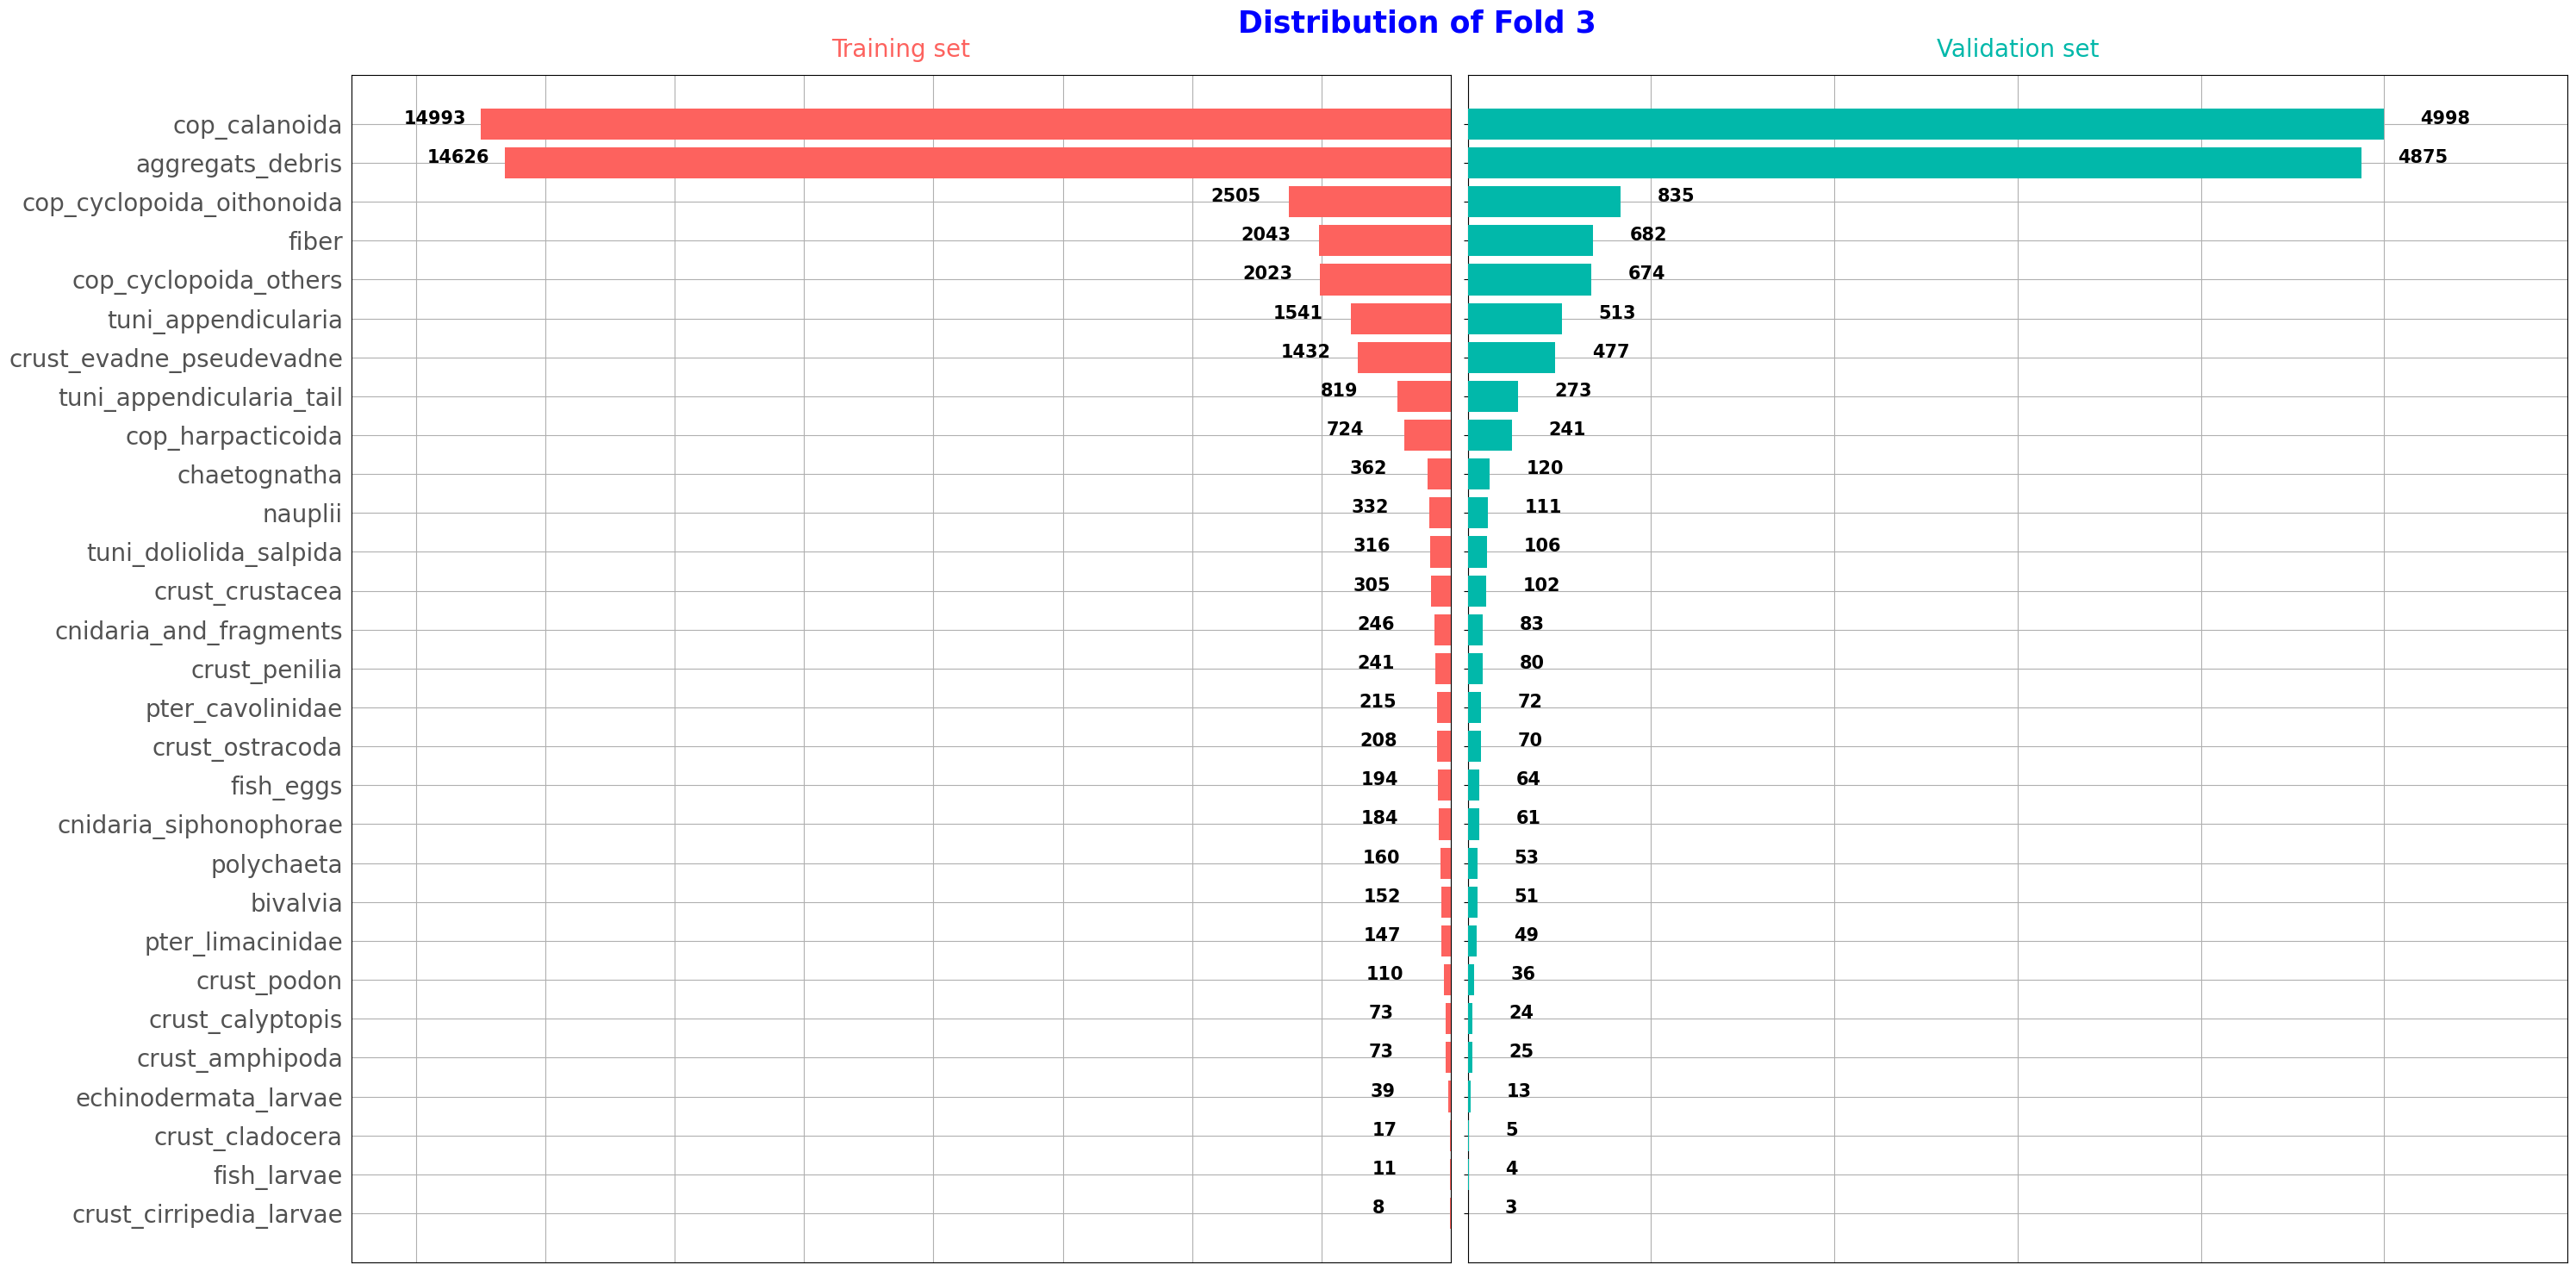

In [252]:
displayBidirectionalCharts(dfFoldTraining_3, 'Training set', dfFoldValidation_3, 'Validation set', 'Distribution of Fold 3')

#### 2.3.1.4. Fold 4

In [253]:
# 1st fold
dfFoldTraining_4 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldValidation_4 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_4.csv')

display(dfFoldTraining_4.head(5), dfFoldTraining_4.shape)
display(dfFoldValidation_4.head(5), dfFoldValidation_4.shape)


,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0002.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0003-aggregates.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0005-aggregates.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0006-aggregates.png,0


(44100, 4)

,filenames,labels,short_filenames,cls
0,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0001-aggregates.png,0
1,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004-aggregates.png,0
2,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0004.png,0
3,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0005-aggregates_002.png,0
4,..//_inputs//_images_Zooscan//_training//aggre...,aggregats_debris,0005.png,0


(14699, 4)

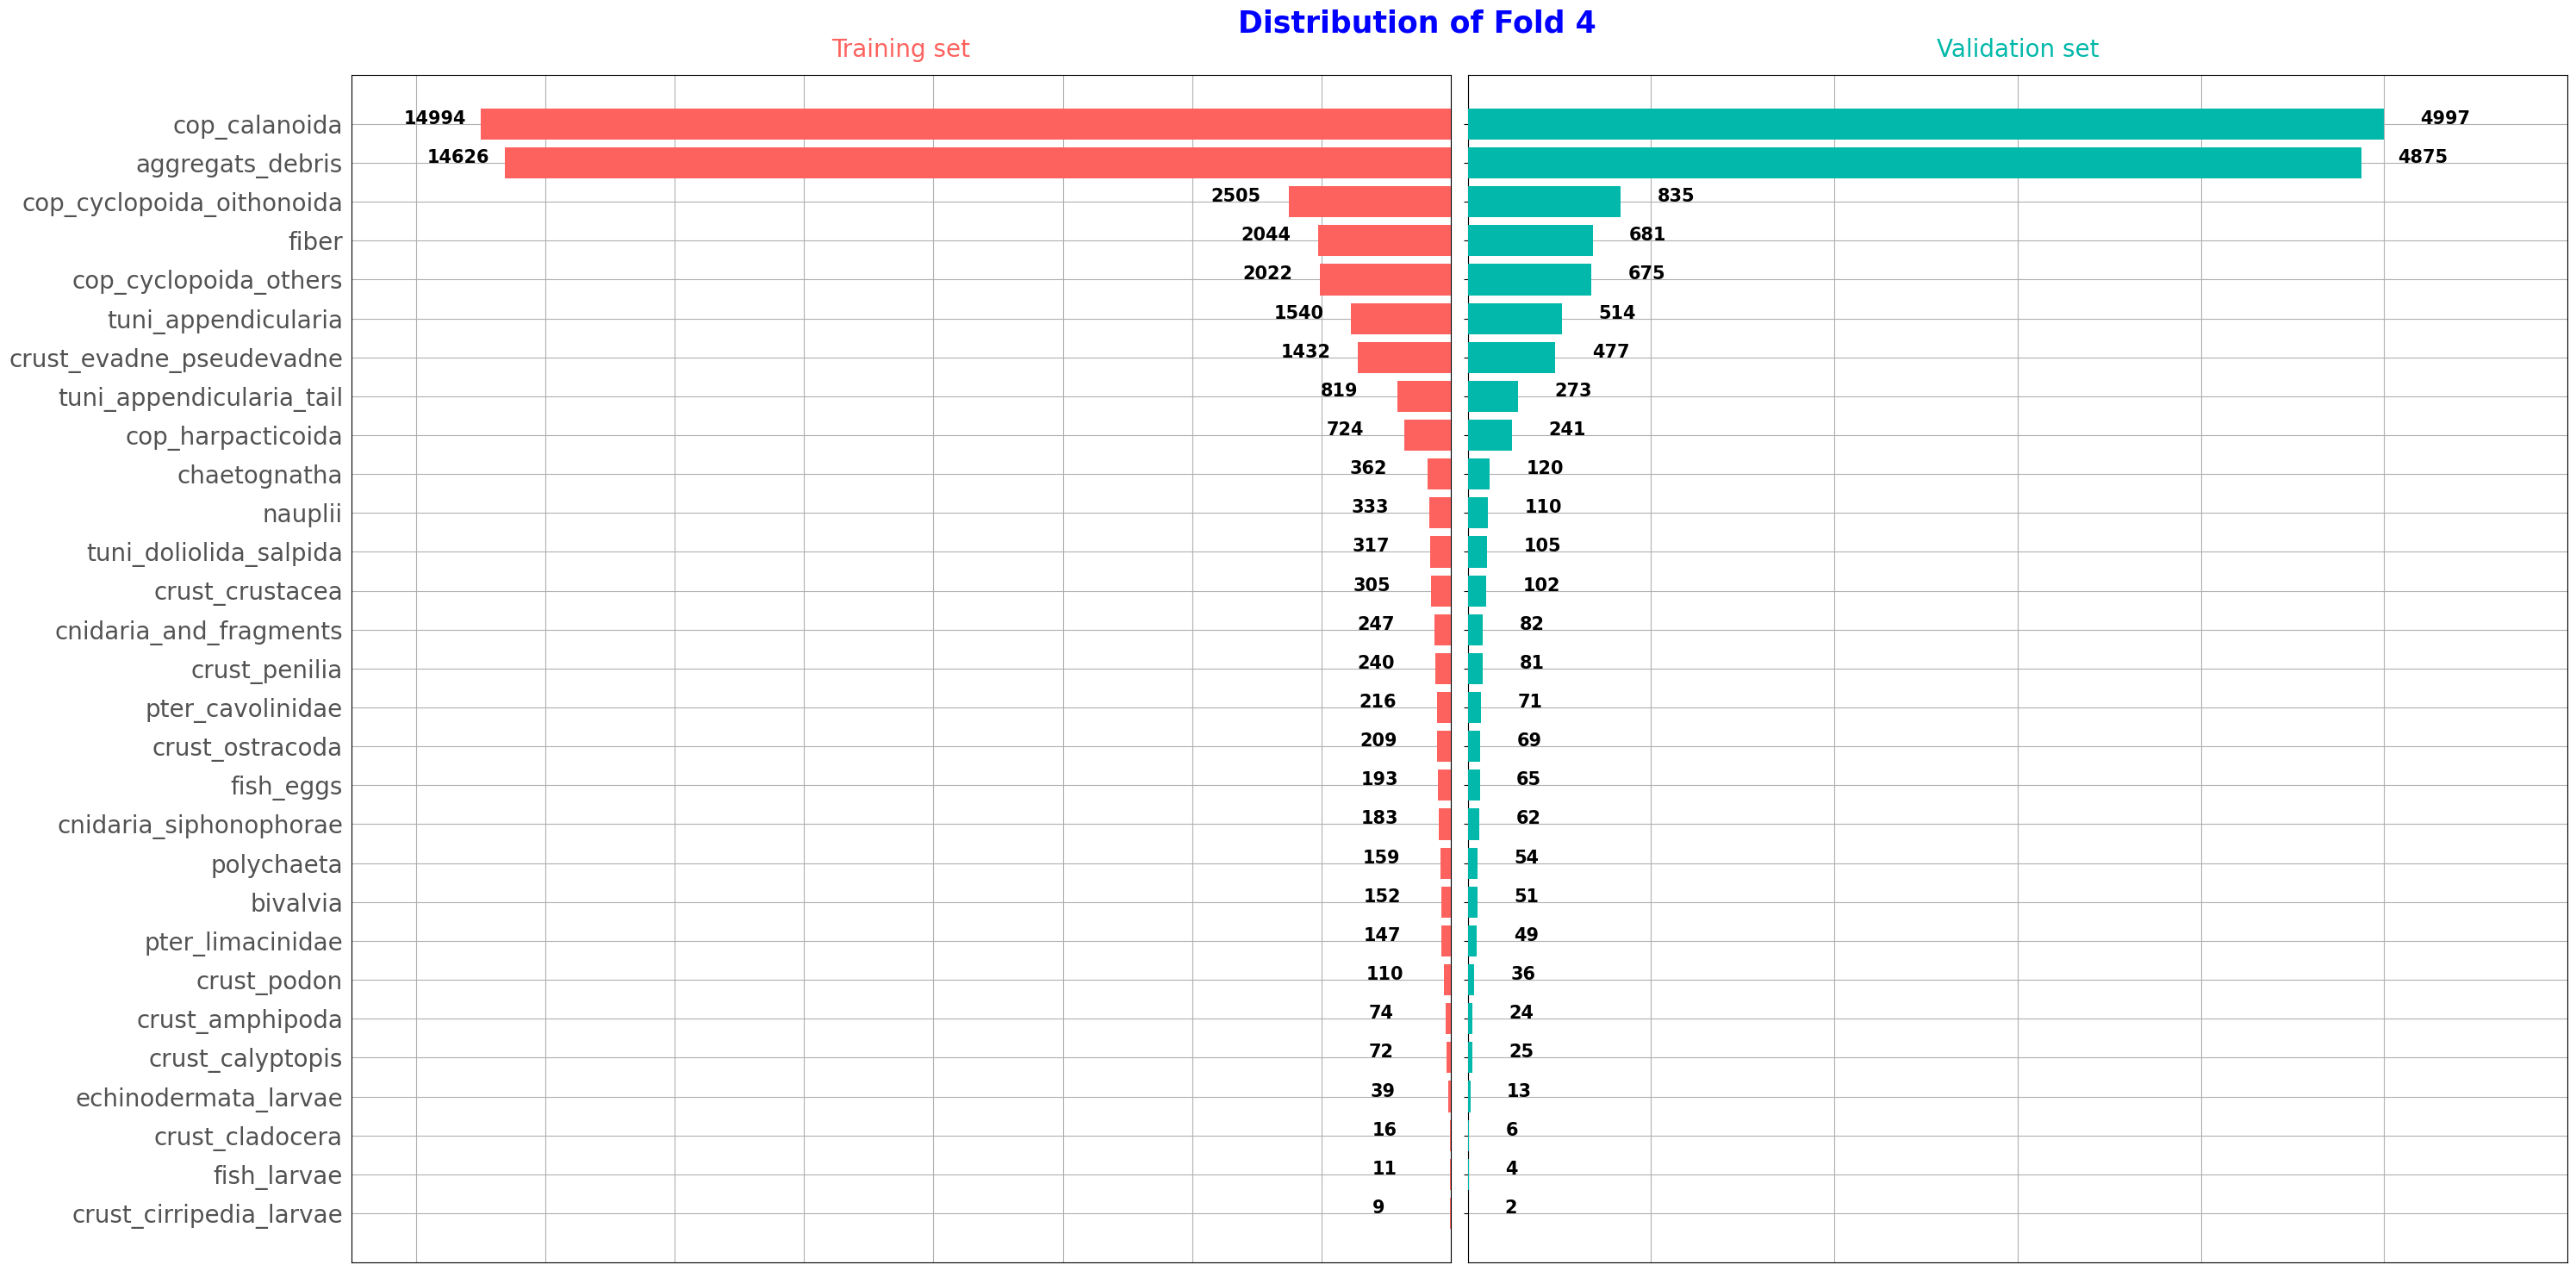

In [254]:
displayBidirectionalCharts(dfFoldTraining_4, 'Training set', dfFoldValidation_4, 'Validation set', 'Distribution of Fold 4')

# 3. Testing some functions for extracting local / texture features on images

## 3.1. SIFT

(26, 128)

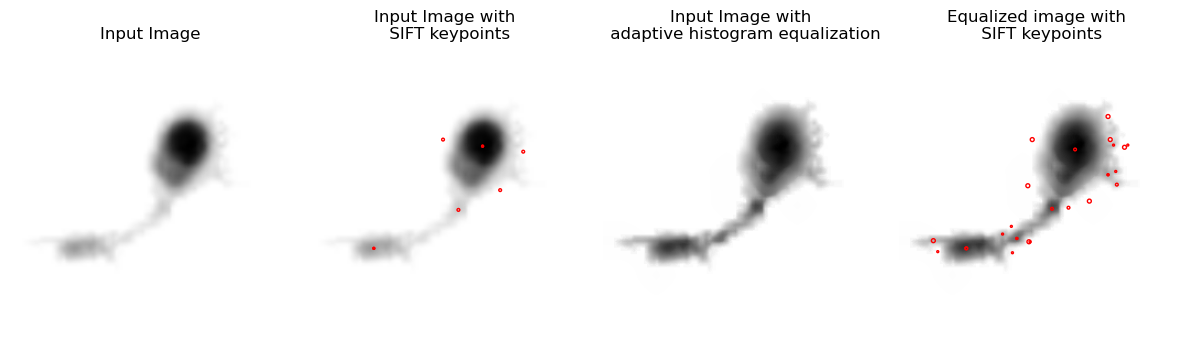

In [257]:
img = io.imread(X_train_df["filenames"][12345], as_gray=True)

img = (resize(img,(256,256))*255).astype(np.uint8)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img)


# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

descriptor_extractor2 = SIFT()
try:
    descriptor_extractor2.detect_and_extract(img_adapteq)
except: 
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.1)
    descriptor_extractor2.detect_and_extract(img_adapteq)
    
display(descriptor_extractor2.descriptors.shape)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))


ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title("Input Image")

ax[1].imshow(img, cmap=plt.cm.gray)
ax[1].scatter(descriptor_extractor.keypoints[:, 1], descriptor_extractor.keypoints[:, 0],
              2 ** descriptor_extractor.scales, facecolors='none', edgecolors='r')
ax[1].set_title('Input Image with \n SIFT keypoints')


ax[2].imshow(img_adapteq, cmap=plt.cm.gray)
ax[2].set_title("Input Image with \n adaptive histogram equalization")


ax[3].imshow(img_adapteq, cmap=plt.cm.gray)
ax[3].scatter(descriptor_extractor2.keypoints[:, 1], descriptor_extractor2.keypoints[:, 0],
              2 ** descriptor_extractor2.scales, facecolors='none', edgecolors='r')
ax[3].set_title('Equalized image with \n SIFT keypoints')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

## 3.2. ORB

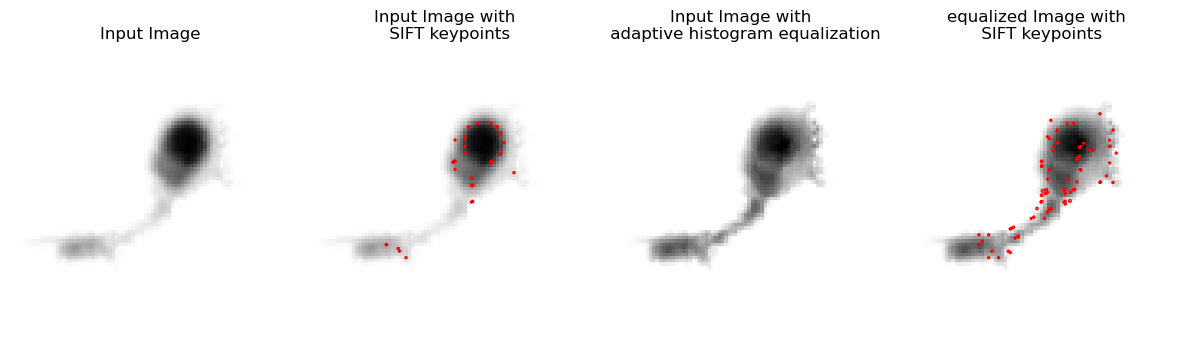

In [258]:
img = io.imread(X_train_df["filenames"][12345], as_gray=True)

img = img/np.max(img)

descriptor_extractor = ORB()

descriptor_extractor.detect_and_extract(img)



# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
descriptor_extractor2 = ORB()

descriptor_extractor2.detect_and_extract(img_adapteq)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))


ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title("Input Image")

ax[1].imshow(img, cmap=plt.cm.gray)
ax[1].scatter(descriptor_extractor.keypoints[:, 1], descriptor_extractor.keypoints[:, 0],
              2 ** descriptor_extractor.scales, facecolors='none', edgecolors='r')
ax[1].set_title('Input Image with \n SIFT keypoints')


ax[2].imshow(img_adapteq, cmap=plt.cm.gray)
ax[2].set_title("Input Image with \n adaptive histogram equalization")


ax[3].imshow(img_adapteq, cmap=plt.cm.gray)
ax[3].scatter(descriptor_extractor2.keypoints[:, 1], descriptor_extractor2.keypoints[:, 0],
              2 ** descriptor_extractor2.scales, facecolors='none', edgecolors='r')
ax[3].set_title('equalized Image with \n SIFT keypoints')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# 4. Extract HOG + PCA features

In [8]:
from tqdm.notebook import tqdm

# import psutil

# def print_mem():
#     print("----------")
#     print("virtual_memory.used: {:.2f}MiB".format(
#             psutil.virtual_memory().used / 1024 ** 2))

## 4.1. Functions

In [9]:
from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

In [14]:
def extract_hog_from_filepath(filepath):
    # read image from its path
    img = io.imread(filepath, as_gray=True)
    
    # resize the image for obtaining the same length of HOG feature 
    img_r = (resize(img,(256,256))*255).astype(np.uint8)
    
    # extract hog feature
    hog_feature = hog(img_r, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=False, feature_vector=True)
    
    #normalization
    # hog_feature=hog_feature/np.linalg.norm(hog_feature)
    
    return hog_feature

def extract_hog(dfDataset):
        
    HOG_features = Parallel(n_jobs=-5)(
                    delayed(extract_hog_from_filepath)(filepath) for filepath in tqdm(dfDataset['filenames'], position=1, desc='Extract HOG')
                )
    
    HOG_list=np.vstack(HOG_features)
    
    return HOG_list

## 4.2. main()

### 4.2.1. For fold 1
#### 1. Read path of fold 1 file

In [69]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

#### 2. Extracting HOG feature for the training set

In [16]:
HOG_list = extract_hog(dfFoldTraining_1)

Extract HOG:   0%|          | 0/44099 [00:00<?, ?it/s]

In [19]:
# Standard deviation normalization
HOG_list_std = StandardScaler().fit_transform(HOG_list)

In [20]:
display(HOG_list_std)

array([[-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106],
       ...,
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08891477, -0.07078106]])

In [21]:
print('Total HOG features:',(HOG_list_std.shape))

Total HOG features: (44099, 2048)


#### 3. PCA analysis on the training set

In [22]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

Text(0.5, 1.0, 'PCA analysis on HOG features of training set')

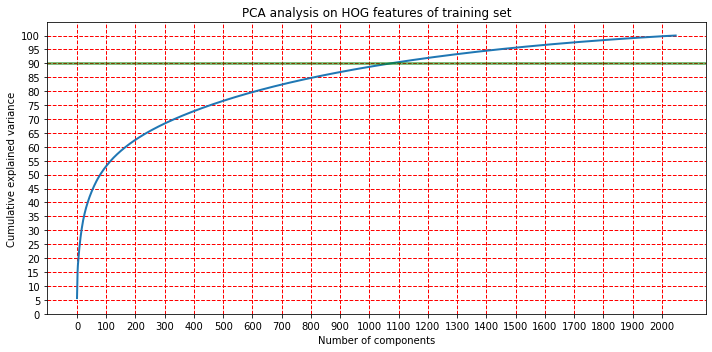

In [23]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [60]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

90.44834037486619

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

##### 3.2. Kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7


Text(0.5, 1.0, 'Scree Plot of PCA: Component Eigenvalues')

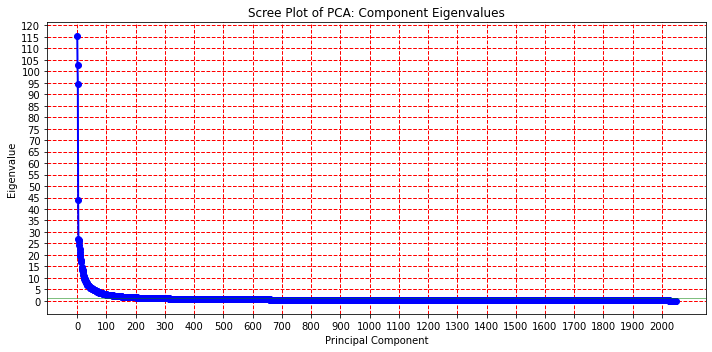

In [53]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(pca_HOG_std.explained_variance_, 'bo-', linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_yticks(np.arange(0,125,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='g', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')

In [54]:
print('\nEigenvalues \n%s' %pca_HOG_std.explained_variance_)
print('Eigenvectors \n%s' %pca_HOG_std.components_)


Eigenvalues 
[1.15568612e+02 1.02669002e+02 9.46843646e+01 ... 9.83031116e-02
 9.43206197e-02 9.08247098e-02]
Eigenvectors 
[[ 0.01395531  0.00990388  0.01375403 ...  0.01237111  0.01375091
   0.01293913]
 [ 0.01194358  0.00841177  0.0112819  ...  0.01011539  0.01155574
   0.01031938]
 [ 0.00438814  0.00259772  0.00384605 ...  0.0035082   0.00417374
   0.00321487]
 ...
 [-0.11619066 -0.03793043  0.06569485 ... -0.01453993  0.06216408
   0.052127  ]
 [ 0.05078577  0.01776065 -0.09553286 ... -0.02083596  0.0406094
   0.02194985]
 [ 0.02113276 -0.00250593 -0.00594427 ... -0.01159366 -0.05829523
   0.01565881]]


In [51]:
# kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7
a = pca_HOG_std.explained_variance_ >= 1.0

In [52]:
a.sum()

309

<b> Only 309 components are significant and should be kept </b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [64]:
# keep 1100 components which contribute to > 90 %
# 
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

Original shape:    (44099, 2048)
Transformed shape: (44099, 1100)


In [67]:
# HOG for train set --- standardization again
std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [68]:
X_HOG_std_train = std_scale_train.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-train-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0001-aggregates.png,0.917532,1.446930,0.205228,-1.107345,-1.733303,0.403580,0.331383,-0.708740,-0.286626,...,-0.270898,-1.451016,0.899651,-2.463982,-0.987813,-0.048611,-1.630682,-0.925515,-0.050534,-0.193231
1,0002.png,0.370330,-0.948398,0.757212,-0.493496,1.038656,-1.259286,-0.124348,-1.532322,-0.717836,...,-0.357295,1.822092,1.283029,-1.077279,1.071682,-1.540096,0.637232,-1.198213,1.238641,-0.047978
2,0003-aggregates.png,2.865927,1.594055,0.677442,1.457901,-0.284414,-2.662969,-0.596255,1.996462,-1.121355,...,-0.535091,-1.585111,-1.376737,0.632967,0.750572,-0.875868,-0.294600,-0.197357,-1.002862,1.066273
3,0004-aggregates.png,-1.317775,1.106078,-0.475630,0.014253,-0.768315,1.132644,0.919119,-1.054055,-1.043923,...,-1.135987,-0.014569,-0.120000,0.610297,-0.340056,0.603698,0.294148,0.372006,-0.373755,-0.030937
4,0004.png,0.805461,-0.246937,1.353345,1.582495,-1.278247,-0.336470,-0.499225,-1.547898,-1.641064,...,-0.210098,0.758822,-0.479687,-0.796292,-0.072482,1.969854,-1.185920,-0.171854,-1.054300,-0.235019


(44099, 1101)

##### 4.2. For validation set

In [82]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

Extract HOG:   0%|          | 0/14700 [00:00<?, ?it/s]

In [83]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list)

In [84]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

Original shape:    (14700, 2048)
Transformed shape: (14700, 1100)


In [85]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train.transform(HOG_PCA_validation)

In [86]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-validation-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0002-aggregates.png,0.298257,0.255083,0.292893,-0.467372,-0.257965,-0.013692,-0.075297,0.163572,0.113494,...,0.455184,0.097085,-0.035765,0.135832,-0.038974,0.070782,0.190121,-0.096206,0.162785,-0.087976
1,0006-aggregates.png,0.346588,0.225019,0.147139,-0.489912,-0.162125,-0.098792,0.154064,-0.348411,0.072942,...,-0.105994,-0.301678,-0.136441,-0.192272,0.337809,0.002536,0.081178,0.054546,-0.009620,0.050443
2,001-aggregates-jo_700_05.png,0.717240,0.391638,0.216370,-0.719850,-0.111205,-0.129360,-0.035828,0.005376,0.132967,...,0.144069,0.194831,-0.259867,0.161476,-0.070078,-0.040351,0.351997,-0.123901,0.102247,-0.142013
3,0010-aggregates.png,0.273310,0.300916,-0.030894,-0.401420,-0.112190,0.223311,-0.125065,-0.217336,-0.083516,...,-0.301402,-0.054836,0.105359,0.064638,0.119123,0.207371,0.160306,0.165494,0.228759,-0.006280
4,0011.png,0.270644,0.039255,-0.225322,-0.095486,-0.096262,-0.007957,-0.043383,0.341273,0.121589,...,-0.137508,-0.110657,-0.003512,-0.003944,-0.052977,0.055669,0.249857,-0.117801,0.013625,-0.109415


(14700, 1101)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [76]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

Extract HOG:   0%|          | 0/6907 [00:00<?, ?it/s]

In [78]:
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list)

In [79]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

Original shape:    (6907, 2048)
Transformed shape: (6907, 1100)


In [80]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train.transform(HOG_PCA_test)

In [81]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-test-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0007-aggregates_002.png,0.296182,0.305782,0.298306,-0.536155,-0.127459,0.072669,-0.066641,-0.082635,0.139469,...,0.243594,-0.035454,-0.322921,-0.319875,0.108522,0.045160,0.138620,-0.158163,-0.072364,0.109416
1,0009-aggregates_001.png,0.438624,-0.002198,-0.056611,-0.253856,-0.000731,0.327538,-0.021575,0.022215,-0.012192,...,0.051604,-0.188822,-0.222409,-0.053537,-0.237467,-0.329579,-0.009140,0.056644,-0.141724,0.005586
2,0012-aggregates_002.png,0.238399,0.045544,0.258127,-0.218885,-0.061346,-0.150953,-0.194469,-0.110764,-0.045394,...,0.126677,0.360795,-0.016809,0.006409,-0.076574,-0.119078,-0.023027,0.051285,-0.081180,-0.084309
3,002-aggregates_001.png,0.436568,0.431434,-0.113930,-0.547088,0.028063,-0.246354,0.002160,0.004458,0.163716,...,-0.070111,-0.128668,0.217713,0.105196,-0.147184,0.541878,0.168127,0.158817,0.294196,-0.175665
4,002-aggregates_007.png,0.524260,0.223370,0.273166,-0.467397,0.336331,-0.168252,0.166397,-0.192716,-0.111137,...,0.082033,0.044856,0.216683,0.064234,-0.062388,-0.051896,0.400953,-0.156204,0.036085,-0.260550


(6907, 1101)

### 4.2.2. For fold 2
#### 1. Read path of fold 2

In [88]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv')

#### 2. Extracting HOG feature for the training set

In [89]:
HOG_list = extract_hog(dfFoldTraining_1)

Extract HOG:   0%|          | 0/44099 [00:00<?, ?it/s]

In [90]:
# Standard deviation normalization
HOG_list_std = StandardScaler().fit_transform(HOG_list)

In [91]:
display(HOG_list_std)

array([[-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554],
       [-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554],
       [-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554],
       ...,
       [-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554],
       [-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554],
       [-0.05001177, -0.03681146, -0.04605917, ..., -0.07239725,
        -0.08944084, -0.07005554]])

In [92]:
print('Total HOG features:',(HOG_list_std.shape))

Total HOG features: (44099, 2048)


#### 3. PCA analysis on the training set

In [93]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

Text(0.5, 1.0, 'PCA analysis on HOG features of training set')

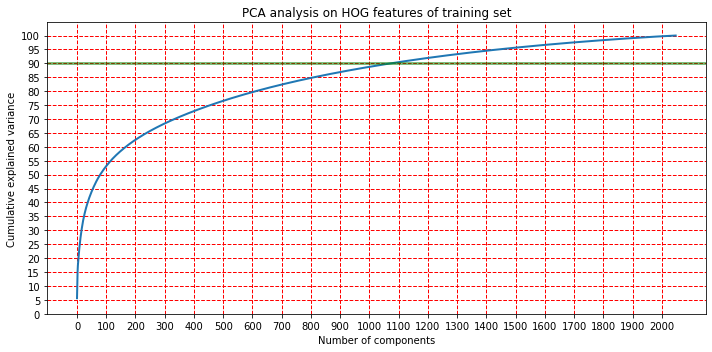

In [94]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [95]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

90.44304983424733

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

##### 3.2. Kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7


Text(0.5, 1.0, 'Scree Plot of PCA: Component Eigenvalues')

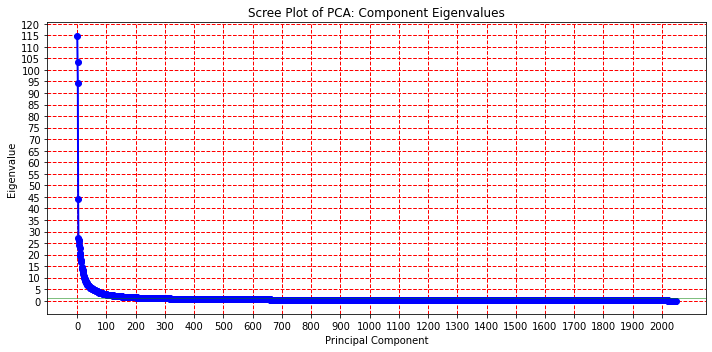

In [96]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(pca_HOG_std.explained_variance_, 'bo-', linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_yticks(np.arange(0,125,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='g', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')

In [97]:
print('\nEigenvalues \n%s' %pca_HOG_std.explained_variance_)
print('Eigenvectors \n%s' %pca_HOG_std.components_)


Eigenvalues 
[1.14858555e+02 1.03228532e+02 9.45251749e+01 ... 9.68034317e-02
 9.38780508e-02 9.27325210e-02]
Eigenvectors 
[[ 0.01420467  0.01093712  0.01416033 ...  0.0118081   0.01421017
   0.01355109]
 [ 0.01191828  0.00920563  0.01141863 ...  0.01024749  0.01154516
   0.01048307]
 [ 0.00393627  0.00257661  0.00345667 ...  0.00320175  0.00385968
   0.00324762]
 ...
 [ 0.12377566 -0.02369238 -0.00853475 ... -0.06290632  0.02408869
   0.0143722 ]
 [-0.05201346 -0.02479931  0.12773183 ... -0.02959976 -0.02963774
   0.01615375]
 [-0.0958326  -0.04219018  0.17351864 ...  0.03914453 -0.01479318
  -0.07041075]]


In [98]:
# kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7
a = pca_HOG_std.explained_variance_ >= 1.0

In [99]:
a.sum()

309

<b> Only 309 components are significant and should be kept </b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [100]:
# keep 1100 components which contribute to > 90 %
# 
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

Original shape:    (44099, 2048)
Transformed shape: (44099, 1100)


In [101]:
# HOG for train set --- standardization again
std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [102]:
X_HOG_std_train = std_scale_train.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-train-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0001-aggregates.png,0.938462,1.427957,0.161889,-1.100882,-1.507096,-0.943766,-0.011826,-0.755550,-0.119392,...,-0.358639,-0.592908,0.623722,1.568735,-0.536868,-0.856330,-0.965180,-1.564384,2.258509,0.947739
1,0002-aggregates.png,-0.016823,0.084428,1.071945,-0.723437,-1.416615,-0.652187,-0.200635,0.926078,0.221000,...,0.160837,-0.581715,-2.758078,1.291152,-0.331464,-0.003231,0.102261,0.184354,-0.983208,-0.611999
2,0004-aggregates.png,-1.308959,1.109050,-0.536586,-0.030515,-0.474074,-1.306296,0.729651,-1.021037,-1.229910,...,0.128858,0.981362,-1.446961,-0.044738,-0.375323,-0.099734,-0.556488,1.382562,-0.955668,1.669883
3,0004.png,0.781993,-0.215020,1.373325,1.607377,-1.279424,-0.093677,-0.750912,-1.525595,-1.385900,...,0.190359,-1.792843,-1.759295,-0.078405,0.203980,-0.553646,-0.406404,-0.102153,0.973211,0.373726
4,0005-aggregates.png,0.220578,-0.742203,-0.718725,0.212694,0.797124,-0.883294,-0.988510,-0.538454,-0.168387,...,-0.787600,0.497951,-0.162462,-0.235953,1.061455,-0.049974,-0.118804,1.872277,-0.789371,0.603424


(44099, 1101)

##### 4.2. For validation set

In [104]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

Extract HOG:   0%|          | 0/14700 [00:00<?, ?it/s]

In [105]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list)

In [106]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

Original shape:    (14700, 2048)
Transformed shape: (14700, 1100)


In [107]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train.transform(HOG_PCA_validation)

In [108]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-validation-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0002.png,0.377785,0.057113,0.237022,-0.393438,0.075475,0.334578,-0.068038,-0.320465,0.017406,...,-0.036865,0.188254,-0.143972,-0.074339,-0.147444,0.132938,0.242329,-0.183639,-0.079677,0.220670
1,0003-aggregates.png,0.689122,0.467412,0.185444,-0.466813,-0.156035,0.348445,-0.250110,0.145236,0.068315,...,-0.146626,-0.138245,-0.160730,0.203222,-0.009327,0.131518,-0.030535,0.051116,0.089401,0.016193
2,0008-aggregates.png,0.167427,-0.032575,0.085919,-0.132555,-0.109836,0.068777,0.164852,-0.030877,0.196364,...,0.231051,0.092166,-0.132707,0.083588,-0.097710,-0.094500,0.106016,-0.093042,0.101702,0.135381
3,001-aggregates_003.png,0.465046,0.655436,0.222848,-0.579094,-0.199695,0.113601,-0.274758,-0.121350,0.256798,...,0.188643,-0.152771,-0.013810,0.177802,0.173339,-0.117299,0.006360,-0.113182,0.087471,0.223040
4,001-aggregates_006.png,0.374366,0.084540,0.067042,-0.395245,0.173292,0.045672,-0.066719,-0.228096,0.066915,...,-0.031580,-0.009009,0.005482,-0.159431,0.135581,-0.106043,-0.037646,-0.163311,0.131879,-0.333684


(14700, 1101)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [109]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [110]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

Extract HOG:   0%|          | 0/6907 [00:00<?, ?it/s]

In [111]:
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list)

In [112]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

Original shape:    (6907, 2048)
Transformed shape: (6907, 1100)


In [113]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train.transform(HOG_PCA_test)

In [114]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_1100_std_features-test-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0007-aggregates_002.png,0.303087,0.309211,0.291452,-0.524785,-0.094457,-0.123122,-0.099741,-0.108519,0.167012,...,0.179990,-0.040459,0.025373,-0.047624,-0.070209,-0.205804,0.039441,-0.111084,0.123798,0.019528
1,0009-aggregates_001.png,0.440957,-0.013195,-0.051585,-0.244510,0.098300,-0.308148,-0.035277,0.008646,-0.011531,...,0.103726,-0.028995,-0.012800,-0.003468,0.171993,0.095613,0.323600,-0.098053,0.017390,0.014364
2,0012-aggregates_002.png,0.239252,0.050110,0.260371,-0.210500,-0.080782,0.124895,-0.211964,-0.126527,0.004385,...,-0.080953,0.000536,0.175294,0.170715,0.002644,-0.035777,0.019028,-0.086246,-0.161602,-0.008600
3,002-aggregates_001.png,0.449514,0.416689,-0.123736,-0.539364,-0.049858,0.228347,-0.000307,-0.029577,0.203549,...,-0.250567,0.224224,0.019101,0.044299,-0.058525,-0.185208,0.300491,0.209753,-0.097159,0.242841
4,002-aggregates_007.png,0.528773,0.219374,0.272557,-0.458982,0.244399,0.253403,0.189276,-0.226522,-0.080394,...,0.304291,-0.104505,0.068364,-0.054223,0.062382,0.203001,0.221394,0.054957,-0.381160,0.390856


(6907, 1101)

### 3.1. Function definition

In [7]:
# SIFT
def extract_SIFT_from_image(fname):   
    img = io.imread(fname, as_gray=True)
#     img = (resize(img,(256,256))*255).astype(np.uint8)
    
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    # extract daisy descriptor
    descriptor_extractor = SIFT()
    try:
        descriptor_extractor.detect_and_extract(img_adapteq)
    except:
        img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.1)
        descriptor_extractor.detect_and_extract(img_adapteq)
        
    sift_feature = descriptor_extractor.descriptors
    
    return sift_feature


def extract_sift_feature_BOVW_from_image(fname,sift_cluster_model):    
    
    sift_features=extract_SIFT_from_image(fname)     
    
    bovw_feature = np.histogram(sift_cluster_model.predict(sift_features), bins=range(sift_cluster_model.n_clusters), density=True)[0]

    return bovw_feature

### 3.2. Work on images of training set

In [10]:
number_of_clusters = 512
batch_size = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_size, n_init="auto")

number_of_batch = len(X_train_df)// batch_size + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)
    
    
for batch in tqdm(list_batches, desc='batch', leave=True, colour='green'):      
    
    sift_descriptor_list = Parallel(n_jobs=8)(
            delayed(extract_SIFT_from_image)(filename) for filename in batch
        )
    
    sift_descriptor_list_concat = np.concatenate(sift_descriptor_list)

    # %reset_selective -f sift_descriptor_list
    del sift_descriptor_list                                
    gc.collect()
                                    
    kmeans = kmeans.partial_fit(sift_descriptor_list_concat)
    
    # %reset_selective -f sift_descriptor_list_concat
                                    
    del sift_descriptor_list_concat
    
    gc.collect()

batch:   0%|          | 0/45 [00:00<?, ?it/s]

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
for batch in list_batches:  
    sift_descriptor_list = Parallel(n_jobs=-1)(
            delayed(extract_SIFT_from_image)(filename) for filename in batch
        )

    # for filname in batch:


    kmeans = kmeans.partial_fit(np.concatenate(sift_descriptor_list))

    del sift_descriptor_list
    gc.collect()

In [15]:
list_batches[0][0]

'..//_inputs//_images//train_processed//aggregats_debris/0001-aggregates.png'

In [7]:
import pickle
# pickle.dump(kmeans, open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", "wb"))

In [8]:
# load the model from disk
loaded_model = pickle.load(open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", 'rb'))

In [9]:
sift_decs = extract_sift_feature_BOVW_from_image(X_train_df["filenames"][40500], loaded_model)

In [10]:
sift_decs.shape

(511,)

In [11]:
sift_features=extract_SIFT_from_image(X_train_df["filenames"][40500]) 

In [ ]:
sift_decs = np.histogram(loaded_model.predict(sift_features), bins=loaded_model.n_clusters, range=(0, loaded_model.n_clusters), density=True)[0]
display(sift_decs)

In [ ]:
sift_decs2 = np.histogram(loaded_model.predict(sift_features), bins=range(loaded_model.n_clusters), density=True)[0]
display(sift_decs2)

In [46]:
sift_decs[0:511] - sift_decs2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
sift_decs[0][0]

0.0

In [63]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)
del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()

        

  0%|          | 0/980 [00:00<?, ?it/s]

batch:   0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/979 [00:00<?, ?it/s]

In [64]:
sift_BOVW.shape

(44099, 511)

In [65]:
X_daisy_train_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(sift_BOVW)

X_daisy_train_std = std_scale_train.transform(sift_BOVW)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-train_df.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0001-aggregates.png,0.00000,0.006791,0.001698,0.001698,0.0,0.005093,0.003396,0.00000,0.000000,...,0.008489,0.0,0.003396,0.001698,0.001698,0.0,0.0,0.001698,0.001698,0.01528
1,0002-aggregates.png,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
2,0002.png,0.03125,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.03125,0.031250,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
3,0003-aggregates.png,0.00000,0.000000,0.007092,0.007092,0.0,0.014184,0.014184,0.00000,0.007092,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
4,0004-aggregates.png,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.032258,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000


(44099, 512)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0001-aggregates.png,-0.373018,1.469236,0.116786,0.944803,-0.226913,2.744226,0.617400,-0.351649,-0.522216,...,5.734915,-0.295913,1.113801,0.787809,0.797435,-0.148433,-0.175304,0.670963,0.288891,6.889195
1,0002-aggregates.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
2,0002.png,2.321612,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,3.103471,1.104535,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
3,0003-aggregates.png,-0.373018,-0.214506,1.139471,4.407242,-0.226913,7.899308,3.280675,-0.351649,-0.153024,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
4,0004-aggregates.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,1.157011,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520


(44099, 512)

In [29]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_validation_df)// batch_sise + 1

list_batches = np.array_split(X_validation_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)
del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()

  0%|          | 0/980 [00:00<?, ?it/s]

batch:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

In [30]:
sift_BOVW.shape

(14700, 511)

In [32]:
std_scale_train

StandardScaler()

In [31]:

X_daisy_validation_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(sift_BOVW)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-validation_df.csv", header=False, index=False)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0001.png,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0002-aggregates_001.png,0.0,0.000000,0.007463,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,0003.png,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0007-aggregates_001.png,0.0,0.018868,0.000000,0.000000,0.0,0.0,0.0,0.006289,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.006289,0.000000
4,0008-aggregates_001.png,0.0,0.006289,0.000000,0.003145,0.0,0.0,0.0,0.006289,0.003145,...,0.0,0.0,0.0,0.0,0.003145,0.025157,0.0,0.0,0.003145,0.018868


(14700, 512)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0001.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
1,0002-aggregates_001.png,-0.373018,-0.214506,1.209709,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
2,0003.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
3,0007-aggregates_001.png,-0.373018,4.463438,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,0.343721,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,1.612397,-0.158520
4,0008-aggregates_001.png,-0.373018,1.344809,-0.205085,1.873481,-0.226913,-0.143986,-0.220818,0.343721,-0.358518,...,-0.141765,-0.295913,-0.152589,-0.150105,1.599012,7.587566,-0.175304,-0.146989,0.705949,8.544005


(14700, 512)

In [35]:
list_batches[0]

0      ..//_inputs//_images//test_processed//aggregat...
1      ..//_inputs//_images//test_processed//aggregat...
2      ..//_inputs//_images//test_processed//aggregat...
3      ..//_inputs//_images//test_processed//aggregat...
4      ..//_inputs//_images//test_processed//aggregat...
                             ...                        
982    ..//_inputs//_images//test_processed//aggregat...
983    ..//_inputs//_images//test_processed//aggregat...
984    ..//_inputs//_images//test_processed//aggregat...
985    ..//_inputs//_images//test_processed//aggregat...
986    ..//_inputs//_images//test_processed//aggregat...
Name: filenames, Length: 987, dtype: object

In [44]:
for fname in tqdm(list_batches[0]):
    sift_fea = extract_SIFT_from_image(fname)
    if sift_fea.shape[0] == 0:
        display(fname)
        break;
    

  0%|          | 0/987 [00:00<?, ?it/s]

RuntimeError: SIFT found no features. Try passing in an image containing greater intensity contrasts between adjacent pixels.

In [61]:
number_of_clusters = 512
batch_sise = 1000

number_of_batch = len(X_test_df)// batch_sise + 1

list_batches = np.array_split(X_test_df["filenames"], number_of_batch)

sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(list_batches[0])
        )

sift_BOVW = np.array(sift_descriptor_list)

display(sift_BOVW.shape)

del sift_descriptor_list
gc.collect()
    
for batch in tqdm(list_batches[1:], desc='batch', position=1, leave=False, colour='green'):    
    sift_descriptor_list = Parallel(n_jobs=6)(
            delayed(extract_sift_feature_BOVW_from_image)(fname, loaded_model) for fname in tqdm(batch)
        )

    sift_BOVW = np.vstack((sift_BOVW, np.array(sift_descriptor_list)))
    
    del sift_descriptor_list
    gc.collect()
    
display(sift_BOVW.shape)

  0%|          | 0/987 [00:00<?, ?it/s]

(987, 511)

batch:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/987 [00:00<?, ?it/s]

  0%|          | 0/987 [00:00<?, ?it/s]

  0%|          | 0/987 [00:00<?, ?it/s]

  0%|          | 0/987 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

(6907, 511)

In [62]:
X_daisy_test_dff = pd.DataFrame(data = sift_BOVW)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-sift_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(sift_BOVW)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-sift_512_std_features-test_df.csv", header=False, index=False)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0007-aggregates_002.png,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.015385,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0009-aggregates_001.png,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.000000,0.0,0.000000
2,0012-aggregates_002.png,0.010753,0.0,0.0,0.0,0.0,0.010753,0.0,0.010753,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021505,0.010753,0.0,0.000000
3,002-aggregates_001.png,0.017544,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.017544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.017544
4,002-aggregates_007.png,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


(6907, 512)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0007-aggregates_002.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,1.349333,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520
1,0009-aggregates_001.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,0.498491,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,5.878531,-0.146989,-0.200499,-0.158520
2,0012-aggregates_002.png,0.554166,-0.214506,-0.205085,-0.144938,-0.226913,5.953350,-0.220818,0.837210,-0.522216,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,6.464386,5.033373,-0.200499,-0.158520
3,002-aggregates_001.png,1.139757,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,0.391048,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,7.933301
4,002-aggregates_007.png,-0.373018,-0.214506,-0.205085,-0.144938,-0.226913,-0.143986,-0.220818,-0.351649,1.272820,...,-0.141765,-0.295913,-0.152589,-0.150105,-0.143161,-0.148433,-0.175304,-0.146989,-0.200499,-0.158520


(6907, 512)

In [ ]:
number_of_clusters = 512
batch_sise = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

for batch in tqdm(list_batches, desc='batch', position=1, leave=False, colour='green'):    

    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering

    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filenames', position=2, leave=True, colour='red'):
        img = io.imread(fname, as_gray=True)
        # extract sift features
        # fname = batch[i]
        sift_features=extract_SIFT_from_image(img)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

    kmeans = kmeans.partial_fit(np.concatenate(daisy_descriptor_list))
    
    del daisy_descriptor_list
    gc.collect()

In [133]:
kmeans = MiniBatchKMeans(n_clusters=10,batch_size=100)

In [127]:
descriptors = Parallel(n_jobs=-1)(
            delayed(extract_SIFT_from_image)(filename) for filename in X_train_df["filenames"][0:100]
        )

In [129]:
np.concatenate(descriptors).shape

(16510, 128)

In [142]:
np.array(descriptors).shape

C:\Users\Le Duong Quoc\AppData\Local\Temp\ipykernel_8308\908551120.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(descriptors).shape


(100,)

In [61]:
kmeans

MiniBatchKMeans(batch_size=1000, n_clusters=512)

In [63]:
import pickle
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [75]:
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [76]:
#Daisy for train set

img = io.imread(X_train_df["filenames"][0])
X_daisy_train = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_train = np.vstack((X_daisy_train, extract_daisy_feature_BOVW_from_image(img,kmeans)))
       

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(X_daisy_train)

X_daisy_train_std = std_scale_train.transform(X_daisy_train)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-train_df.csv", header=False, index=False)


  0%|          | 0/44098 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png,0.000000,0.600734,0.000000,0.004483,0.013449,0.0,0.026899,0.0,0.013449,...,0.004483,0.0,0.0,0.0,0.000000,0.008966,0.000000,0.004483,0.0,0.0
1,0002-aggregates.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.144338,0.000000,0.000000,0.000000,0.0,0.0
2,0002.png,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.0,0.000000,...,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0003-aggregates.png,0.020934,0.481471,0.041867,0.083734,0.020934,0.0,0.083734,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0004-aggregates.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.076923,0.0,0.0,0.0,0.000000,0.000000,0.153846,0.000000,0.0,0.0


(44099, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png,-0.284909,8.117899,-0.201124,-0.363883,1.878064,-0.131042,0.170111,-0.149454,7.114735,...,-0.280129,-0.295327,0.0,0.0,-0.420672,0.781920,-0.510770,0.317645,0.0,0.0
1,0002-aggregates.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,2.801136,-0.152607,-0.510770,-0.200180,0.0,0.0
2,0002.png,-0.284909,-0.223996,-0.201124,1.345794,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.172594,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0
3,0003-aggregates.png,0.767919,6.461793,2.046163,1.203858,3.008585,-0.131042,1.463472,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0
4,0004-aggregates.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,1.775679,-0.295327,0.0,0.0,-0.420672,-0.152607,1.748742,-0.200180,0.0,0.0


(44099, 513)

In [78]:
del X_daisy_train, X_daisy_train_std, X_daisy_train_dff, X_daisy_train_df, X_daisy_train_df, X_daisy_train_df

gc.collect()

NameError: name 'X_daisy_train' is not defined

In [79]:
#daisy for validation set
img = io.imread(X_validation_df["filenames"][0])
X_daisy_validation = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_validation = np.vstack((X_daisy_validation, extract_daisy_feature_BOVW_from_image(img,kmeans)))
    

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(X_daisy_validation)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-validation_df.csv", header=False, index=False)


  0%|          | 0/14699 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001.png,0.062994,0.000000,0.000000,0.000000,0.0,0.0,0.062994,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.125988,0.0,0.0,0.0
1,0002-aggregates_001.png,0.034320,0.034320,0.017160,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.01716,0.0,0.0,0.0,0.0,0.051480,0.0,0.0,0.0
2,0003.png,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0007-aggregates_001.png,0.000000,0.000000,0.000000,0.127114,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.042371,0.0,0.0,0.0
4,0008-aggregates_001.png,0.021477,0.092353,0.010739,0.002148,0.0,0.0,0.004295,0.0,0.0,...,0.004295,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


(14700, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001.png,2.883309,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,0.991509,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,1.339597,-0.20018,0.0,0.0
1,0002-aggregates_001.png,1.441173,0.252576,0.719967,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,0.283109,0.0,0.0,-0.420672,-0.152607,0.245306,-0.20018,0.0,0.0
2,0003.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.20018,0.0,0.0
3,0007-aggregates_001.png,-0.284909,-0.223996,-0.201124,2.062000,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,0.111531,-0.20018,0.0,0.0
4,0008-aggregates_001.png,0.795275,1.058434,0.375295,-0.410081,-0.153491,-0.131042,-0.344248,-0.149454,-0.055874,...,-0.285453,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.20018,0.0,0.0


(14700, 513)

In [80]:
del X_daisy_validation, X_daisy_validation_std, X_daisy_validation_dff, X_daisy_validation_df

gc.collect()

1036

In [81]:
# daisy for test set
    
img = io.imread(X_test_df["filenames"][0])
X_daisy_test = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_test = np.vstack((X_daisy_test, extract_daisy_feature_BOVW_from_image(img,kmeans)))

    
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(X_daisy_test)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-test_df.csv", header=False, index=False)


  0%|          | 0/6906 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0007-aggregates_002.png,0.000000,0.000000,0.000000,0.0,0.053,0.0,0.000000,0.0,0.053,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.053000,0.000000,0.0,0.0
1,0009-aggregates_001.png,0.000000,0.000000,0.088823,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.088823,0.0,0.0,0.0,0.000000,0.0,0.044412,0.000000,0.0,0.0
2,0012-aggregates_002.png,0.000000,0.011988,0.000000,0.0,0.000,0.0,0.011988,0.0,0.000,...,0.003996,0.0,0.0,0.0,0.003996,0.0,0.000000,0.003996,0.0,0.0
3,002-aggregates_001.png,0.133631,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.133631,0.000000,0.0,0.0
4,002-aggregates_007.png,0.000000,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.106600,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


(6907, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0007-aggregates_002.png,-0.284909,-0.223996,-0.201124,-0.452568,7.852316,-0.131042,-0.441997,-0.149454,28.201546,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,0.267630,-0.200180,0.0,0.0
1,0009-aggregates_001.png,-0.284909,-0.223996,4.566614,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.113395,-0.295327,0.0,0.0,-0.420672,-0.152607,0.141495,-0.200180,0.0,0.0
2,0012-aggregates_002.png,-0.284909,-0.057532,-0.201124,-0.452568,-0.153491,-0.131042,-0.169202,-0.149454,-0.055874,...,-0.293954,-0.295327,0.0,0.0,-0.331478,-0.152607,-0.510770,0.261373,0.0,0.0
3,002-aggregates_001.png,6.435897,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,1.451840,-0.200180,0.0,0.0
4,002-aggregates_007.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.617904,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0


(6907, 513)

In [82]:
del X_daisy_test, X_daisy_test_std, X_daisy_test_dff, X_daisy_test_df

gc.collect()

33

In [107]:
fname = X_train_df["filenames"][0]
img = io.imread(fname, as_gray=True)
sift_features=extract_SIFT_from_image(img)

sift_descriptors =sift_features

for fname in tqdm(X_train_df["filenames"][1:100], desc='filenames', position=2, leave=True, colour='red'):
    img = io.imread(fname, as_gray=True)
    
    sift_features=extract_SIFT_from_image(img)
    
    sift_descriptors = np.concatenate(sift_features)
    

filenames:   0%|          | 0/99 [00:00<?, ?it/s]

In [108]:
sift_descriptors.shape

(3584,)

In [115]:
kmeans.fit(np.concatenate(descriptors))

MiniBatchKMeans(batch_size=100, n_clusters=10)

In [116]:
np.concatenate(descriptors).shape

(2800, 128)

In [119]:
def _descriptors_to_histogram(descriptors, dictionary):
    return np.histogram(
        dictionary.predict(descriptors), bins=range(dictionary.n_clusters), density=True
    )[0]

X_trans = Parallel(n_jobs=-1)(
            delayed(_descriptors_to_histogram)(descr_img,kmeans)
            for descr_img in descriptors
        )


In [123]:
X_trans = Parallel(n_jobs=-1)(
            delayed(_descriptors_to_histogram)(descr_img,kmeans)
            for descr_img in descriptors
        )


In [125]:
X_trans[0]

array([0.14285714, 0.10714286, 0.07142857, 0.07142857, 0.03571429,
       0.14285714, 0.21428571, 0.07142857, 0.14285714])

In [126]:
np.sum(X_trans[0])

1.0

## 3.1. HOG and LBPH extraction

In [12]:
# DAISY 
def extract_daisy_from_image(img):            
    # extract daisy feature
    descs = daisy(img, step=8, radius=8, rings=2, histograms=8,orientations=8, visualize=False)
   
    # calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptor = descs.reshape(descs_num,descs.shape[2])
    
    return daisy_desriptor

def extract_daisy_feature_BOVW_from_image(fname,daisy_cluster_model):

    
    daisy_features=extract_daisy_from_image(fname)     
    
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector) # normalize the histogram

    return bovw_feature

# HOG
def extract_hog_from_image(img):    
    # resize the image for obtaining the same length of HOG feature 
    img_r = (resize(img,(256,256))*255).astype(np.uint8)
    # extract hog feature
    hog_feature = hog(img_r, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=False, feature_vector=True)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    return hog_feature

# Local Binary Pattern

def stride_split(image: np.ndarray, kernel_size: tuple):
    # Image & Tile dimensions
    img_height, img_width = image.shape
    tile_height, tile_width = kernel_size

    # bytelength of a single element
    bytelength = image.nbytes // image.size

    tiled_array = np.lib.stride_tricks.as_strided(
        image,
        shape=(img_height // tile_height,
               img_width // tile_width,
               tile_height,
               tile_width),
        strides=(img_width*tile_height*bytelength,
                 tile_width*bytelength,
                 img_width*bytelength,
                 bytelength)
    )
    return tiled_array

def extract_lbp_from_image(img):    
    # get image size
    img_height, img_width = img.shape
    
    # display(img)
    # get kernel size
    num_cells = 4
    
    img_height_new = img_height
    img_width_new = img_width
    if img_height%num_cells != 0:
        img_height_new = img_height - img_height%num_cells + num_cells
    if img_width%num_cells != 0:
        img_width_new = img_width - img_width%num_cells + num_cells
        
    image_r = (resize(img,(img_height_new,img_width_new))*255).astype(np.uint8)
    # image_r = imagfe_r.astype(np.uint8)
    img_height, img_width = image_r.shape
    
    # display(image_r)
    
    # display(img_height, img_width)
    
    kernel_size = (int(img_height//num_cells), int(img_width//num_cells))
    
    # display(kernel_size, kernel_size)
    
    # split the image into 16 cells
    tiled_array = stride_split(image_r, kernel_size)  
    
    # display(tiled_array[1,1,:,:])
    
    # fig = plt.figure(figsize=(10, 10))
    # for i in range(tiled_array.shape[0]):
    #     # print(i)
    #     for j in range(tiled_array.shape[1]):
    #         # print(j)
    #         ax = plt.subplot(tiled_array.shape[0], tiled_array.shape[1], tiled_array.shape[0]*i + j+1)
    #         ax.imshow(tiled_array[i,j,:,:],cmap='gray', vmin=0, vmax=255)
    #         # ax.imshow(tiled_array[i,j,:,:],cmap='Greys_r')
    #         ax.axes.xaxis.set_visible(False)
    #         ax.axes.yaxis.set_visible(False)
    # plt.tight_layout()
    # plt.show()

    # extract lbp feature
    n_points=72
    radius=2
    n_bins = n_points
    METHOD='uniform'


    lbp = local_binary_pattern(tiled_array[0,0,:,:], n_points, radius, METHOD)
    hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
                                                              
    # display(hist.shape)
    
    for i in range(tiled_array.shape[0]):
        for j in range(tiled_array.shape[1]):
            lbp = local_binary_pattern(tiled_array[i,j,:,:], n_points, radius, METHOD)
            histij, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins))
            hist = np.concatenate([hist.ravel(), histij.ravel()])
        
    return hist[n_points:]


# gabor filter

def createGaborfilterbank(m=39, n=39):
    garray = []
    fmax = 0.327 # maximum frequency
    gamma = np.sqrt(2)
    eta = np.sqrt(2)
    
    gamma = 0.5
    eta = 0.5
    
    u = 6 #number of frequencies
    v = 8 #number of orientation

    for i in range(0,u):

        fu = fmax/np.sqrt(2)**(i);
        alpha = fu/gamma;
        beta = fu/eta;

        for j in range(0,v):
            theta = j/v*np.pi;

            x, y = np.meshgrid(np.arange(1,n+1,1), np.arange(1,m+1,1))

            xenvolope  =  (x-((m+1)/2))*np.cos(theta) + (y-((n+1)/2))*np.sin(theta);
            yenvolope  = -(x-((m+1)/2))*np.sin(theta) + (y-((n+1)/2))*np.cos(theta);
            
            gfilter = np.transpose(
                                (fu**2/(np.pi*gamma*eta))*np.exp(-((alpha**2)*(xenvolope**2) + 
                              (beta**2)*(yenvolope**2)))*np.exp(1j*2*np.pi*fu*xenvolope)
                                    );

            garray.append(gfilter);

#     plt.figure(figsize=(30,20))

#     for i in range(48):    
#         ax = plt.subplot(6,8,i+1)
#         # ax.set_title(label)
#         plt.imshow(np.real(garray[i]),cmap='Greys_r')
#         plt.axis("off")  
        
    return garray

def computeGaborfeatures(image, kernels):
    feats = []
    filteredimg = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, np.abs(kernel), mode='wrap')
            
        feats.append(filtered.mean())
        feats.append(filtered.std())
        
        filteredimg.append(filtered)
        
    return feats, filteredimg

In [13]:
from tqdm.notebook import tqdm

### 3.2. merge training and validation sets because we want to perform k-ford cross validations

In [14]:
# HOG for training data

img = io.imread(X_train_df["filenames"][0])

HOG_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_list=np.vstack((HOG_list,HOG_features))
    

        
print('Total HOG features:',(HOG_list.shape))

pca_HOG = PCA().fit(HOG_list)

fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_HOG.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))

ax.set_title("PCA analysis on HOG features of training set")

  0%|          | 0/44098 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'PCA analysis on HOG features of training set')

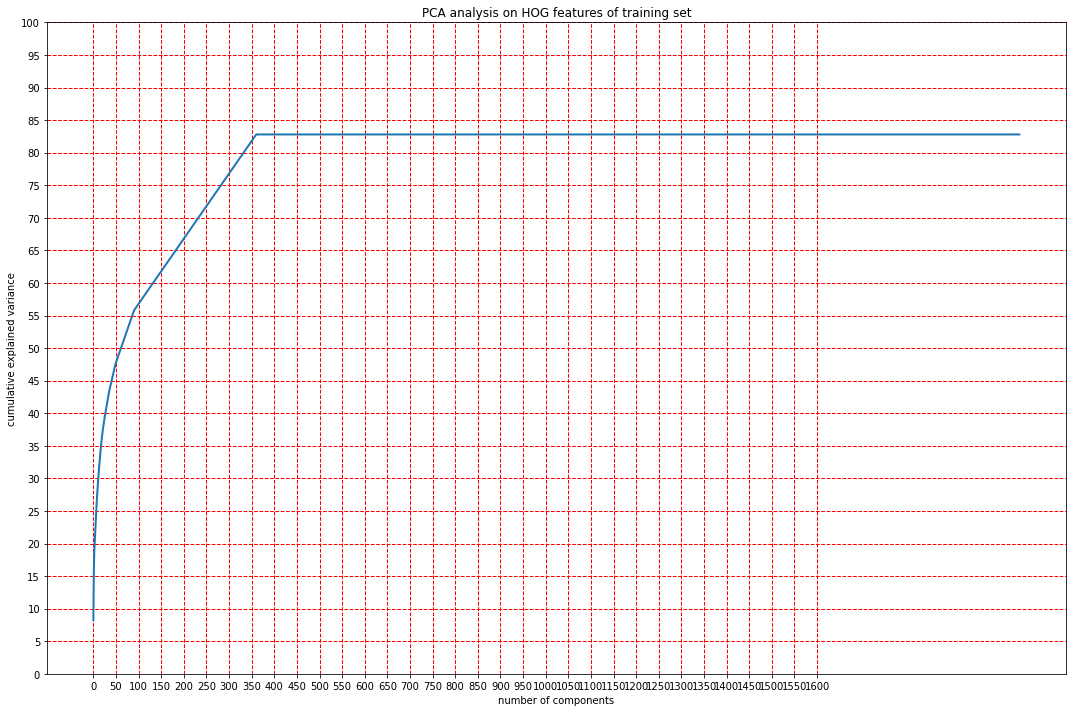

In [15]:
fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_HOG.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,1650,50))
ax.set_title("PCA analysis on HOG features of training set")

In [17]:
# LBP for training data

img = io.imread(X_train_df["filenames"][0])

LBP_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_list=np.vstack((LBP_list,LBP_features))
    

        
print('Total LBP features:',(LBP_list.shape))

pca_LBP = PCA().fit(LBP_list)


  0%|          | 0/44098 [00:00<?, ?it/s]

Total LBP features: (44099, 1152)


Text(0.5, 1.0, 'PCA analysis on LBP features of training set')

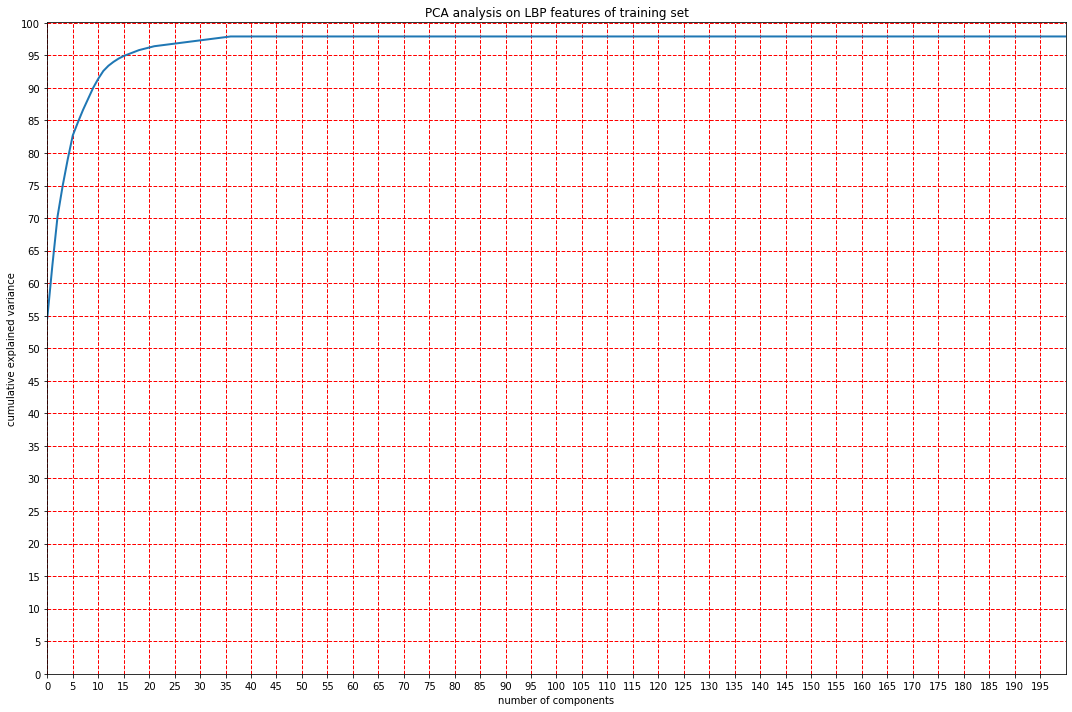

In [31]:
fig, ax = plt.subplots(figsize=(15, 10), tight_layout=True)

ax.plot(np.cumsum(np.round(pca_LBP.explained_variance_ratio_, decimals=3)*100), linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,200,5))
ax.set_xlim((0,200))

ax.set_title("PCA analysis on LBP features of training set")

In [16]:
# 2.2. PCA for HOG features

# For training set
pca_HOG_2 = PCA(n_components=350)
pca_HOG_2.fit(HOG_list)
HOG_PCA_train = pca_HOG_2.transform(HOG_list)
print("original shape:   ", HOG_list.shape)
print("transformed shape:", HOG_PCA_train.shape)



original shape:    (44099, 2048)
transformed shape: (44099, 350)


In [17]:
# HOG for train set
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_train)
X_HOG_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-train_df.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0001-aggregates.png,0.031221,-0.049379,0.203829,-0.044573,-0.003130,0.075118,0.026522,-0.085271,-0.001868,...,0.005248,-0.017952,0.003197,-0.004324,-0.001106,0.011581,0.020874,-0.006318,0.011205,-0.004399
1,0002-aggregates.png,0.022920,0.165467,0.100414,-0.072801,0.138035,0.024415,0.016906,-0.040072,0.021774,...,-0.006815,0.004664,-0.010670,-0.027290,-0.013210,-0.002323,-0.012354,0.000299,0.001558,-0.008257
2,0002.png,-0.194805,0.146053,0.023918,0.071159,-0.187477,-0.126349,0.039978,-0.009894,-0.073817,...,0.002402,0.008867,0.007793,0.000184,0.004021,0.033178,0.012826,0.000270,-0.000383,-0.006900
3,0003-aggregates.png,-0.022325,-0.002567,0.256233,-0.074723,0.019863,-0.092200,0.030811,0.075586,-0.060717,...,0.015874,-0.015990,-0.007104,-0.015941,-0.005265,0.004946,0.003434,-0.007037,0.016397,-0.003519
4,0004-aggregates.png,0.429120,-0.111331,-0.060102,0.052297,-0.067102,0.159118,0.024355,0.011956,0.022626,...,-0.016754,0.009927,-0.011563,0.023401,-0.017018,-0.009259,-0.021143,-0.014235,0.006528,-0.010099


(44099, 351)

In [19]:
# HOG for train set --- standardization
std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)

X_HOG_std_train = std_scale_train.transform(HOG_PCA_train)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-train_df.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0001-aggregates.png,0.139691,-0.232188,1.470620,-0.464596,-0.032989,0.795475,0.282299,-0.947723,-0.022191,...,0.304650,-1.046009,0.186147,-0.252532,-0.064980,0.681603,1.232823,-0.373651,0.662995,-0.260777
1,0002-aggregates.png,0.102552,0.778056,0.724483,-0.758828,1.455042,0.258548,0.179947,-0.445368,0.258708,...,-0.395653,0.271731,-0.621299,-1.593665,-0.776183,-0.136736,-0.729636,0.017668,0.092170,-0.489534
2,0002.png,-0.871625,0.686770,0.172569,0.741707,-1.976211,-1.337986,0.425522,-0.109965,-0.877048,...,0.139425,0.516639,0.453765,0.010719,0.236253,1.952748,0.757488,0.015978,-0.022636,-0.409058
3,0003-aggregates.png,-0.099891,-0.012068,1.848719,-0.778856,0.209373,-0.976370,0.327951,0.840082,-0.721396,...,0.921570,-0.931672,-0.413642,-0.930922,-0.309334,0.291102,0.202831,-0.416157,0.970174,-0.208603
4,0004-aggregates.png,1.920028,-0.523500,-0.433633,0.545108,-0.707335,1.685003,0.259234,0.132882,0.268829,...,-0.972665,0.578407,-0.673313,1.366572,-0.999942,-0.544968,-1.248720,-0.841818,0.386243,-0.598716


(44099, 351)

In [21]:
# For validation set
img = io.imread(X_validation_df["filenames"][0])

HOG_validation_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_validation_list=np.vstack((HOG_validation_list,HOG_features))
    

        
print('Total HOG features of validation set:',(HOG_validation_list.shape))

HOG_PCA_validation = pca_HOG_2.transform(HOG_validation_list)

# store to file
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_validation)
X_HOG_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-validation_df.csv", header=False, index=False)

# store to file with standardization
X_HOG_std_validation = std_scale_train.transform(HOG_PCA_validation)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-validation_df.csv", header=False, index=False)

100%|████████████████████████████████████████████████████████████████████████████| 14699/14699 [11:21<00:00, 21.57it/s]


Total HOG features of validation set: (14700, 2048)


,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0001.png,0.205439,-0.301390,0.053342,0.033215,-0.108468,-0.018169,0.051353,0.018049,0.071374,...,0.008508,0.001949,0.004651,-0.016655,-0.006052,0.058375,0.035462,-0.027613,-0.021701,0.009687
1,0002-aggregates_001.png,-0.208445,-0.088319,0.121242,-0.093189,0.025380,0.078698,-0.005270,-0.097305,-0.140270,...,0.002922,-0.006513,-0.003161,0.015575,0.003517,0.011006,0.007830,-0.002876,-0.004012,0.008618
2,0003.png,-0.129384,0.221635,0.268818,0.089158,0.016251,0.041571,-0.029364,0.124674,-0.078778,...,0.034316,-0.007288,0.001604,0.037906,-0.010845,0.005989,0.001635,-0.012618,-0.028338,-0.005847
3,0007-aggregates_001.png,-0.063754,-0.067659,0.213100,-0.044215,-0.039713,0.058179,0.072429,-0.066272,-0.036393,...,0.019772,0.005693,0.010421,0.012430,0.005254,0.025522,0.009693,0.011439,-0.005293,0.010134
4,0008-aggregates_001.png,-0.383489,-0.015002,-0.059514,0.090720,0.006343,0.080849,0.003486,-0.032848,-0.079278,...,-0.015412,-0.000403,0.004359,-0.005588,-0.001001,-0.007627,-0.022238,0.015018,-0.008413,-0.005493


(14700, 351)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0001.png,0.919204,-1.417190,0.384859,0.346214,-1.143368,-0.192408,0.546592,0.200604,0.848014,...,0.493924,0.113534,0.270812,-0.972588,-0.355600,3.435740,2.094380,-1.632964,-1.283966,0.574282
1,0002-aggregates_001.png,-0.932651,-0.415293,0.874757,-0.971341,0.267537,0.833388,-0.056096,-1.081478,-1.666603,...,0.169622,-0.379510,-0.184056,0.909558,0.206670,0.647778,0.462431,-0.170102,-0.237353,0.510942
2,0003.png,-0.578907,1.042170,1.939513,0.929318,0.171308,0.440223,-0.312548,1.385669,-0.935986,...,1.992259,-0.424658,0.093370,2.213608,-0.637245,0.352468,0.096537,-0.746166,-1.676679,-0.346650
3,0007-aggregates_001.png,-0.285256,-0.318144,1.537510,-0.460872,-0.418615,0.616091,0.770927,-0.736571,-0.432394,...,1.147857,0.331699,0.606810,0.725874,0.308707,1.502131,0.572484,0.676490,-0.313200,0.600771
4,0008-aggregates_001.png,-1.715859,-0.070543,-0.429391,0.945606,0.066867,0.856161,0.037109,-0.365080,-0.941930,...,-0.894750,-0.023490,0.253827,-0.326336,-0.058809,-0.448885,-1.313360,0.888092,-0.497791,-0.325635


(14700, 351)

In [22]:
# For test set

img = io.imread(X_test_df["filenames"][0])

HOG_test_list=extract_hog_from_image(img)
# display(HOG_features)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract HOG features
    HOG_features=extract_hog_from_image(img)
    
    # display(HOG_features)
    # save in a map    
    HOG_test_list=np.vstack((HOG_test_list,HOG_features))
    

print('Total HOG features of test set:',(HOG_test_list.shape))

HOG_PCA_test = pca_HOG_2.transform(HOG_test_list)

# store to file
X_HOG_train_dff = pd.DataFrame(data = HOG_PCA_test)
X_HOG_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_features-test_df.csv", header=False, index=False)

# store to file with standardization
X_HOG_std_test = std_scale_train.transform(HOG_PCA_test)

X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_PCA_350_std_features-test_df.csv", header=False, index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 6906/6906 [03:34<00:00, 32.14it/s]


Total HOG features of test set: (6907, 2048)


,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0007-aggregates_002.png,0.063552,0.168327,0.104512,0.011906,-0.012762,0.098906,-0.017181,-0.163963,-0.026417,...,0.021872,-0.033444,-0.001677,-0.018506,0.025935,-0.011332,0.002209,-0.001321,-0.032301,0.006620
1,0009-aggregates_001.png,-0.343700,-0.132783,0.156239,0.062053,0.101830,0.139428,-0.102866,0.217479,0.054832,...,-0.001678,0.002273,0.011446,-0.004180,0.003672,0.020458,0.016864,0.044441,-0.019972,0.020762
2,0012-aggregates_002.png,-0.137097,0.281207,-0.109558,-0.123044,-0.097350,-0.017524,0.018052,0.082554,0.064661,...,0.013190,-0.008240,-0.024137,0.010635,0.012998,0.035715,-0.003042,-0.002820,0.014479,-0.007475
3,002-aggregates_001.png,0.029442,-0.189139,0.141045,0.059794,0.004275,-0.048832,0.061339,-0.029813,0.079146,...,0.013336,-0.021653,0.048935,0.010039,-0.011060,-0.005589,-0.007148,0.006308,0.011054,-0.010944
4,002-aggregates_007.png,-0.096691,0.124347,0.166589,0.186723,-0.087230,-0.066706,-0.004725,0.066506,-0.068977,...,-0.013095,-0.004992,0.028981,-0.020629,-0.019999,-0.002371,0.040337,0.002418,0.002082,-0.002787


(6907, 351)

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0007-aggregates_002.png,0.284352,0.791505,0.754052,0.124096,-0.134528,1.047380,-0.182873,-1.822332,-0.313868,...,1.269776,-1.948617,-0.097633,-1.080680,1.523870,-0.666931,0.130485,-0.078135,-1.911192,0.392460
1,0009-aggregates_001.png,-1.537830,-0.624368,1.127264,0.646793,1.073401,1.476495,-1.094895,2.417124,0.651477,...,-0.097402,0.132430,0.666486,-0.244101,0.215767,1.204106,0.995981,2.628058,-1.181694,1.230885
2,0012-aggregates_002.png,-0.613418,1.322289,-0.790460,-1.282525,-1.026174,-0.185576,0.192142,0.917529,0.768263,...,0.765760,-0.480135,-1.405422,0.621041,0.763743,2.102022,-0.179665,-0.166789,0.856694,-0.443161
3,002-aggregates_001.png,0.131731,-0.889366,1.017633,0.623250,0.045066,-0.517109,0.652882,-0.331348,0.940363,...,0.774214,-1.261604,2.849391,0.586271,-0.649863,-0.328956,-0.422178,0.373043,0.654062,-0.648804
4,002-aggregates_007.png,-0.432628,0.584700,1.201933,1.946268,-0.919502,-0.706397,-0.050290,0.739168,-0.819541,...,-0.760227,-0.290853,1.687514,-1.204693,-1.175073,-0.139531,2.382291,0.143011,0.123211,-0.165237


(6907, 351)

In [33]:
# 2.2. PCA for LBP features

# For training set
pca_LBP_2 = PCA(n_components=35)
pca_LBP_2.fit(LBP_list)
LBP_PCA_train = pca_LBP_2.transform(LBP_list)
print("original shape:   ", LBP_list.shape)
print("transformed shape:", LBP_PCA_train.shape)
# Fsave LBP PCA for train set
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_train)
X_LBP_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-train_df.csv", header=False, index=False)
# LBP for train set --- standardization
std_scale_train = preprocessing.StandardScaler().fit(LBP_PCA_train)

X_LBP_std_train = std_scale_train.transform(LBP_PCA_train)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_train)
X_LBP_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-train_df.csv", header=False, index=False)





# For validation set
img = io.imread(X_validation_df["filenames"][0])

LBP_validation_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_validation_list=np.vstack((LBP_validation_list,LBP_features))
    

        
print('Total LBP features of validation set:',(LBP_validation_list.shape))

LBP_PCA_validation = pca_LBP_2.transform(LBP_validation_list)


# store to file
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_validation)
X_LBP_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-validation_df.csv", header=False, index=False)

# store to file with standardization
X_LBP_std_validation = std_scale_train.transform(LBP_PCA_validation)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_validation)
X_LBP_train_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-validation_df.csv", header=False, index=False)











# For test set

img = io.imread(X_test_df["filenames"][0])

LBP_test_list=extract_lbp_from_image(img)
# display(LBP_features)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    
    # extract LBP features
    LBP_features=extract_lbp_from_image(img)
    
    # display(LBP_features)
    # save in a map    
    LBP_test_list=np.vstack((LBP_test_list,LBP_features))
    

print('Total LBP features of test set:',(LBP_test_list.shape))

LBP_PCA_test = pca_LBP_2.transform(LBP_test_list)

# store to file
X_LBP_train_dff = pd.DataFrame(data = LBP_PCA_test)
X_LBP_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_features-test_df.csv", header=False, index=False)

# store to file with standardization
X_LBP_std_test = std_scale_train.transform(LBP_PCA_test)

X_LBP_train_dff = pd.DataFrame(data = X_LBP_std_test)
X_LBP_train_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_LBP_train_df = pd.concat([X_LBP_train_df,X_LBP_train_dff], axis=1)
X_LBP_train_df.columns = pd.RangeIndex(X_LBP_train_df.columns.size)

display(X_LBP_train_df.head(5), X_LBP_train_df.shape)

X_LBP_train_df.to_csv("..//_inputs//_image_features//new//X-LBP_PCA_350_std_features-test_df.csv", header=False, index=False)

original shape:    (44099, 1152)
transformed shape: (44099, 35)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0001-aggregates.png,0.303761,0.169002,-0.204338,-0.231455,-0.307378,0.057616,0.223413,0.013375,0.058556,...,0.065128,0.092849,0.013569,0.004441,0.034248,0.000671,0.007507,0.009934,0.003475,-0.015633
1,0002-aggregates.png,-0.606817,-0.254566,0.138166,-0.025592,0.184965,0.088694,-0.013122,-0.303294,0.057475,...,0.001711,-0.024213,-0.013972,-0.044067,-0.006391,0.004024,-0.006561,0.004064,-0.002773,-0.006396
2,0002.png,-0.441671,0.341750,0.178925,-0.163407,-0.236005,0.063114,-0.134318,0.264349,0.021952,...,-0.006837,-0.011180,0.009095,0.026528,0.014774,-0.011448,-0.000066,-0.007570,0.002104,0.021810
3,0003-aggregates.png,-0.112682,0.192070,0.076492,0.025071,-0.239924,0.055175,-0.022261,-0.037046,0.050306,...,0.031644,0.064260,0.022178,0.017227,-0.052355,0.006047,0.017256,-0.000320,0.001326,0.025888
4,0004-aggregates.png,-0.297975,0.081064,-0.417065,-0.011887,-0.307051,-0.051306,-0.043421,0.129275,-0.139210,...,0.036533,0.011409,0.028937,0.031729,0.026351,-0.014024,-0.016506,0.000207,-0.024285,-0.015870


(44099, 36)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0001-aggregates.png,0.469336,0.677160,-0.860571,-1.221734,-1.740067,0.340922,1.814138,0.110978,0.506583,...,2.454084,3.520882,0.538365,0.193380,1.521292,0.030624,0.352870,0.484387,0.170692,-0.775217
1,0002-aggregates.png,-0.937583,-1.019996,0.581886,-0.135086,1.047091,0.524817,-0.106556,-2.516543,0.497234,...,0.064460,-0.918162,-0.554358,-1.919046,-0.283890,0.183554,-0.308416,0.198159,-0.136229,-0.317163
2,0002.png,-0.682418,1.369325,0.753543,-0.862541,-1.336026,0.373453,-1.090674,2.193397,0.189909,...,-0.257636,-0.423945,0.360876,1.155224,0.656251,-0.522198,-0.003118,-0.369118,0.103377,1.081545
3,0003-aggregates.png,-0.174103,0.769586,0.322145,0.132339,-1.358213,0.326481,-0.180758,-0.307381,0.435212,...,1.192394,2.436770,0.879947,0.750212,-2.325605,0.275834,0.811166,-0.015619,0.065154,1.283763
4,0004-aggregates.png,-0.460396,0.324808,-1.756468,-0.062744,-1.738216,-0.303586,-0.352579,1.072644,-1.204337,...,1.376601,0.432619,1.148123,1.381718,1.170504,-0.639722,-0.775880,0.010118,-1.192962,-0.786987


(44099, 36)

  0%|          | 0/14699 [00:00<?, ?it/s]

Total LBP features of validation set: (14700, 1152)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0001.png,-0.199871,-0.075022,-0.615946,0.068041,0.098127,-0.019975,-0.033132,0.272049,-0.127035,...,0.012790,-0.011344,-0.016100,-0.005377,0.010034,-0.000488,-0.019360,0.005192,-0.013441,-0.013054
1,0002-aggregates_001.png,0.055544,0.265413,0.151861,-0.430806,0.194142,0.199677,0.254428,-0.162564,-0.013654,...,-0.039078,0.005783,-0.009021,0.011871,-0.015690,0.026707,-0.029658,-0.004636,-0.029036,0.011592
2,0003.png,-1.293569,0.009381,0.328583,0.320831,0.144534,-0.073347,0.109392,-0.035408,0.244059,...,0.007959,0.000113,-0.020694,-0.029858,0.100647,0.059536,0.033582,-0.043233,-0.034816,-0.020701
3,0007-aggregates_001.png,-0.240932,0.255441,-0.046559,-0.262741,-0.214706,0.104053,0.137493,0.100286,0.023702,...,-0.011208,-0.044850,0.020430,-0.001022,-0.004727,-0.024612,-0.000056,-0.008373,-0.033720,-0.006109
4,0008-aggregates_001.png,0.599077,0.219554,0.139584,-0.065425,0.009269,-0.087727,0.165710,0.050064,0.067438,...,0.033461,0.020310,0.024151,-0.001276,0.019014,0.021766,0.054615,-0.021969,0.006625,-0.013696


(14700, 36)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0001.png,-0.308817,-0.300597,-2.594058,0.359154,0.555499,-0.118196,-0.269032,2.257293,-1.099006,...,0.481952,-0.430169,-0.638781,-0.234157,0.445698,-0.022276,-0.910043,0.253189,-0.660275,-0.647328
1,0002-aggregates_001.png,0.085820,1.063457,0.639562,-2.274006,1.099038,1.181519,2.065981,-1.348854,-0.118126,...,-1.472484,0.219286,-0.357933,0.516978,-0.696931,1.218272,-1.394119,-0.226037,-1.426359,0.574813
2,0003.png,-1.998671,0.037587,1.383828,1.693502,0.818207,-0.434008,0.888272,-0.293793,2.111416,...,0.299899,0.004281,-0.821045,-1.300244,4.470689,2.715781,1.578607,-2.108120,-1.710267,-1.026537
3,0007-aggregates_001.png,-0.372260,1.023504,-0.196085,-1.386878,-1.215450,0.615699,1.116458,0.832111,0.205054,...,-0.422328,-1.700745,0.810589,-0.044510,-0.209965,-1.122689,-0.002618,-0.408278,-1.656439,-0.302961
4,0008-aggregates_001.png,0.925624,0.879712,0.587857,-0.345346,0.052470,-0.519093,1.345582,0.415398,0.583418,...,1.260841,0.770150,0.958236,-0.055556,0.844584,0.992882,2.567284,-1.071244,0.325463,-0.679148


(14700, 36)

  0%|          | 0/6906 [00:00<?, ?it/s]

Total LBP features of test set: (6907, 1152)


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0007-aggregates_002.png,-0.147369,-0.227364,0.093932,-0.185113,-0.114192,0.044056,0.125622,0.056398,0.050479,...,-0.020012,-0.011665,-0.011294,0.026741,-0.005985,0.018462,0.024702,-0.022938,-0.014936,-0.004039
1,0009-aggregates_001.png,0.515333,0.493279,0.227448,0.513846,0.356880,-0.254770,-0.006408,-0.146239,-0.016535,...,-0.022846,-0.004051,-0.001244,0.011580,-0.018894,-0.005150,-0.008390,-0.022495,0.014587,0.016021
2,0012-aggregates_002.png,0.784604,-0.203185,0.313396,0.057664,-0.170433,-0.215546,0.117716,0.034058,-0.259158,...,-0.016434,0.007334,-0.004791,0.005650,0.007570,0.016817,-0.009624,-0.012895,0.002931,0.034340
3,002-aggregates_001.png,-0.869467,0.132528,-0.280579,0.087049,0.018540,-0.248563,-0.013175,0.022241,-0.128296,...,0.009284,0.034794,0.032662,0.026941,-0.042626,-0.013444,-0.001208,-0.009788,-0.037515,-0.033140
4,002-aggregates_007.png,-0.632699,0.065954,0.249126,-0.047964,0.060973,-0.137390,-0.065841,0.270517,0.136965,...,-0.062751,-0.028656,-0.046272,0.046766,-0.006915,-0.016192,0.013386,-0.016792,-0.033239,-0.019100


(6907, 36)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0007-aggregates_002.png,-0.227698,-0.911004,0.395595,-0.977118,-0.646443,0.260689,1.020062,0.467952,0.436706,...,-0.754072,-0.442328,-0.448118,1.164525,-0.265831,0.842136,1.161172,-1.118483,-0.733688,-0.200294
1,0009-aggregates_001.png,0.796232,1.976475,0.957897,2.712333,2.020298,-1.507515,-0.052038,-1.213398,-0.143051,...,-0.860858,-0.153628,-0.049353,0.504277,-0.839251,-0.234911,-0.394403,-1.096887,0.716560,0.794479
2,0012-aggregates_002.png,1.212278,-0.814124,1.319867,0.304380,-0.964822,-1.275421,0.955867,0.282594,-2.242042,...,-0.619251,0.278109,-0.190110,0.246066,0.336269,0.767140,-0.452383,-0.628767,0.144001,1.702874
3,002-aggregates_001.png,-1.343399,0.531015,-1.181657,0.459490,0.104957,-1.470787,-0.106980,0.184542,-1.109923,...,0.349827,1.319417,1.295917,1.173210,-1.893427,-0.613269,-0.056774,-0.477281,-1.842877,-1.643369
4,002-aggregates_007.png,-0.977573,0.264265,1.049194,-0.253177,0.345167,-0.812957,-0.534632,2.244581,1.184914,...,-2.364545,-1.086635,-1.835903,2.036576,-0.307157,-0.738629,0.629234,-0.818792,-1.632820,-0.947120


(6907, 36)

In [46]:
del HOG_PCA_train, HOG_PCA_validation, HOG_PCA_test

In [41]:
del X_LBP_train_df

In [24]:
data = [[0, 0], [0, 0], [1, 1], [1, 1]]

In [26]:
scaler = preprocessing.StandardScaler()

In [28]:
scaler.fit(data)

StandardScaler()

In [29]:
print(scaler.mean_)

[0.5 0.5]


In [34]:
print(np.sqrt(scaler.var_))

[0.5 0.5]


In [36]:
# daisy for training data

daisy_descriptor_list=[]

for fname in tqdm(X_train_df["filenames"]):
    img = io.imread(fname)
    
    # extract HOG features
    daisy_features=extract_daisy_from_image(img)
    
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

100%|██████████████████████████████████████████████████████████████████████████| 44099/44099 [3:02:33<00:00,  4.03it/s]


In [60]:

number_of_clusters = 512
batch_sise = 1000

kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_train_df)// batch_sise + 1

list_batches = np.array_split(X_train_df["filenames"], number_of_batch)

for batch in tqdm(list_batches, desc='batch', position=1, leave=False, colour='green'):    

    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering

    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filenames', position=2, leave=True, colour='red'):
        img = io.imread(fname)
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(img)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

    kmeans = kmeans.partial_fit(daisy_descriptor_list)
    
    del daisy_descriptor_list
    gc.collect()

# daisy_descriptor_list=[]

# for fname in tqdm(X_train_df["filenames"]):
#     img = io.imread(fname)
    
#     # extract HOG features
#     daisy_features=extract_daisy_from_image(img)
    
#     daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

batch:   0%|          | 0/45 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/980 [00:00<?, ?it/s]

filenames:   0%|          | 0/979 [00:00<?, ?it/s]

In [61]:
kmeans

MiniBatchKMeans(batch_size=1000, n_clusters=512)

In [63]:
import pickle

In [75]:
pickle.dump(kmeans, open("..//_inputs//_image_features//new//daisy_kmeans_512_model.pkl", "wb"))

In [76]:
#Daisy for train set

img = io.imread(X_train_df["filenames"][0])
X_daisy_train = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_train_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_train = np.vstack((X_daisy_train, extract_daisy_feature_BOVW_from_image(img,kmeans)))
       

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-train_df.csv", header=False, index=False)

# standardized version of daisy train set
std_scale_train = preprocessing.StandardScaler().fit(X_daisy_train)

X_daisy_train_std = std_scale_train.transform(X_daisy_train)

X_daisy_train_dff = pd.DataFrame(data = X_daisy_train_std)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-train_df.csv", header=False, index=False)


  0%|          | 0/44098 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png,0.000000,0.600734,0.000000,0.004483,0.013449,0.0,0.026899,0.0,0.013449,...,0.004483,0.0,0.0,0.0,0.000000,0.008966,0.000000,0.004483,0.0,0.0
1,0002-aggregates.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.144338,0.000000,0.000000,0.000000,0.0,0.0
2,0002.png,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.000000,0.0,0.000000,...,0.090909,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0003-aggregates.png,0.020934,0.481471,0.041867,0.083734,0.020934,0.0,0.083734,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0004-aggregates.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.076923,0.0,0.0,0.0,0.000000,0.000000,0.153846,0.000000,0.0,0.0


(44099, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png,-0.284909,8.117899,-0.201124,-0.363883,1.878064,-0.131042,0.170111,-0.149454,7.114735,...,-0.280129,-0.295327,0.0,0.0,-0.420672,0.781920,-0.510770,0.317645,0.0,0.0
1,0002-aggregates.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,2.801136,-0.152607,-0.510770,-0.200180,0.0,0.0
2,0002.png,-0.284909,-0.223996,-0.201124,1.345794,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.172594,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0
3,0003-aggregates.png,0.767919,6.461793,2.046163,1.203858,3.008585,-0.131042,1.463472,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0
4,0004-aggregates.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,1.775679,-0.295327,0.0,0.0,-0.420672,-0.152607,1.748742,-0.200180,0.0,0.0


(44099, 513)

In [78]:
del X_daisy_train, X_daisy_train_std, X_daisy_train_dff, X_daisy_train_df, X_daisy_train_df, X_daisy_train_df

gc.collect()

NameError: name 'X_daisy_train' is not defined

In [79]:
#daisy for validation set
img = io.imread(X_validation_df["filenames"][0])
X_daisy_validation = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_validation_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_validation = np.vstack((X_daisy_validation, extract_daisy_feature_BOVW_from_image(img,kmeans)))
    

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-validation_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_validation_std = std_scale_train.transform(X_daisy_validation)

X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation_std)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-validation_df.csv", header=False, index=False)


  0%|          | 0/14699 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001.png,0.062994,0.000000,0.000000,0.000000,0.0,0.0,0.062994,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.125988,0.0,0.0,0.0
1,0002-aggregates_001.png,0.034320,0.034320,0.017160,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.01716,0.0,0.0,0.0,0.0,0.051480,0.0,0.0,0.0
2,0003.png,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0007-aggregates_001.png,0.000000,0.000000,0.000000,0.127114,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.042371,0.0,0.0,0.0
4,0008-aggregates_001.png,0.021477,0.092353,0.010739,0.002148,0.0,0.0,0.004295,0.0,0.0,...,0.004295,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


(14700, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001.png,2.883309,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,0.991509,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,1.339597,-0.20018,0.0,0.0
1,0002-aggregates_001.png,1.441173,0.252576,0.719967,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,0.283109,0.0,0.0,-0.420672,-0.152607,0.245306,-0.20018,0.0,0.0
2,0003.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.20018,0.0,0.0
3,0007-aggregates_001.png,-0.284909,-0.223996,-0.201124,2.062000,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,0.111531,-0.20018,0.0,0.0
4,0008-aggregates_001.png,0.795275,1.058434,0.375295,-0.410081,-0.153491,-0.131042,-0.344248,-0.149454,-0.055874,...,-0.285453,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.20018,0.0,0.0


(14700, 513)

In [80]:
del X_daisy_validation, X_daisy_validation_std, X_daisy_validation_dff, X_daisy_validation_df

gc.collect()

1036

In [81]:
# daisy for test set
    
img = io.imread(X_test_df["filenames"][0])
X_daisy_test = extract_daisy_feature_BOVW_from_image(img,kmeans)

for fname in tqdm(X_test_df["filenames"][1:]):
    img = io.imread(fname)
    X_daisy_test = np.vstack((X_daisy_test, extract_daisy_feature_BOVW_from_image(img,kmeans)))

    
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_features-test_df.csv", header=False, index=False)

# standardized version of daisy validation set
X_daisy_test_std = std_scale_train.transform(X_daisy_test)

X_daisy_test_dff = pd.DataFrame(data = X_daisy_test_std)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//new//X-daisy_512_std_features-test_df.csv", header=False, index=False)


  0%|          | 0/6906 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0007-aggregates_002.png,0.000000,0.000000,0.000000,0.0,0.053,0.0,0.000000,0.0,0.053,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.053000,0.000000,0.0,0.0
1,0009-aggregates_001.png,0.000000,0.000000,0.088823,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.088823,0.0,0.0,0.0,0.000000,0.0,0.044412,0.000000,0.0,0.0
2,0012-aggregates_002.png,0.000000,0.011988,0.000000,0.0,0.000,0.0,0.011988,0.0,0.000,...,0.003996,0.0,0.0,0.0,0.003996,0.0,0.000000,0.003996,0.0,0.0
3,002-aggregates_001.png,0.133631,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.133631,0.000000,0.0,0.0
4,002-aggregates_007.png,0.000000,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000,...,0.106600,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


(6907, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0007-aggregates_002.png,-0.284909,-0.223996,-0.201124,-0.452568,7.852316,-0.131042,-0.441997,-0.149454,28.201546,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,0.267630,-0.200180,0.0,0.0
1,0009-aggregates_001.png,-0.284909,-0.223996,4.566614,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.113395,-0.295327,0.0,0.0,-0.420672,-0.152607,0.141495,-0.200180,0.0,0.0
2,0012-aggregates_002.png,-0.284909,-0.057532,-0.201124,-0.452568,-0.153491,-0.131042,-0.169202,-0.149454,-0.055874,...,-0.293954,-0.295327,0.0,0.0,-0.331478,-0.152607,-0.510770,0.261373,0.0,0.0
3,002-aggregates_001.png,6.435897,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,-0.407356,-0.295327,0.0,0.0,-0.420672,-0.152607,1.451840,-0.200180,0.0,0.0
4,002-aggregates_007.png,-0.284909,-0.223996,-0.201124,-0.452568,-0.153491,-0.131042,-0.441997,-0.149454,-0.055874,...,2.617904,-0.295327,0.0,0.0,-0.420672,-0.152607,-0.510770,-0.200180,0.0,0.0


(6907, 513)

In [82]:
del X_daisy_test, X_daisy_test_std, X_daisy_test_dff, X_daisy_test_df

gc.collect()

33

In [ ]:


# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_1024//daisy_kmeans_1024.pkl", "wb"))

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

148

148

(37, 37)

(37, 37)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 203, 184, 158],
       [255, 255, 255, ..., 160, 141, 118],
       [255, 255, 255, ..., 118, 105,  93]], dtype=uint8)

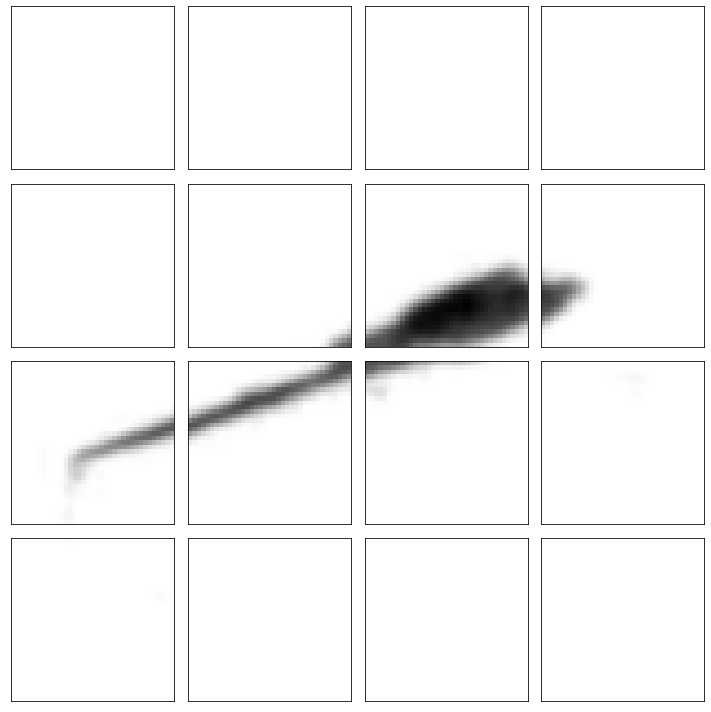

(72,)

In [ ]:
lbp = extract_lbp_from_image(rgb2gray(img))

In [ ]:
lbp.shape

(1152,)

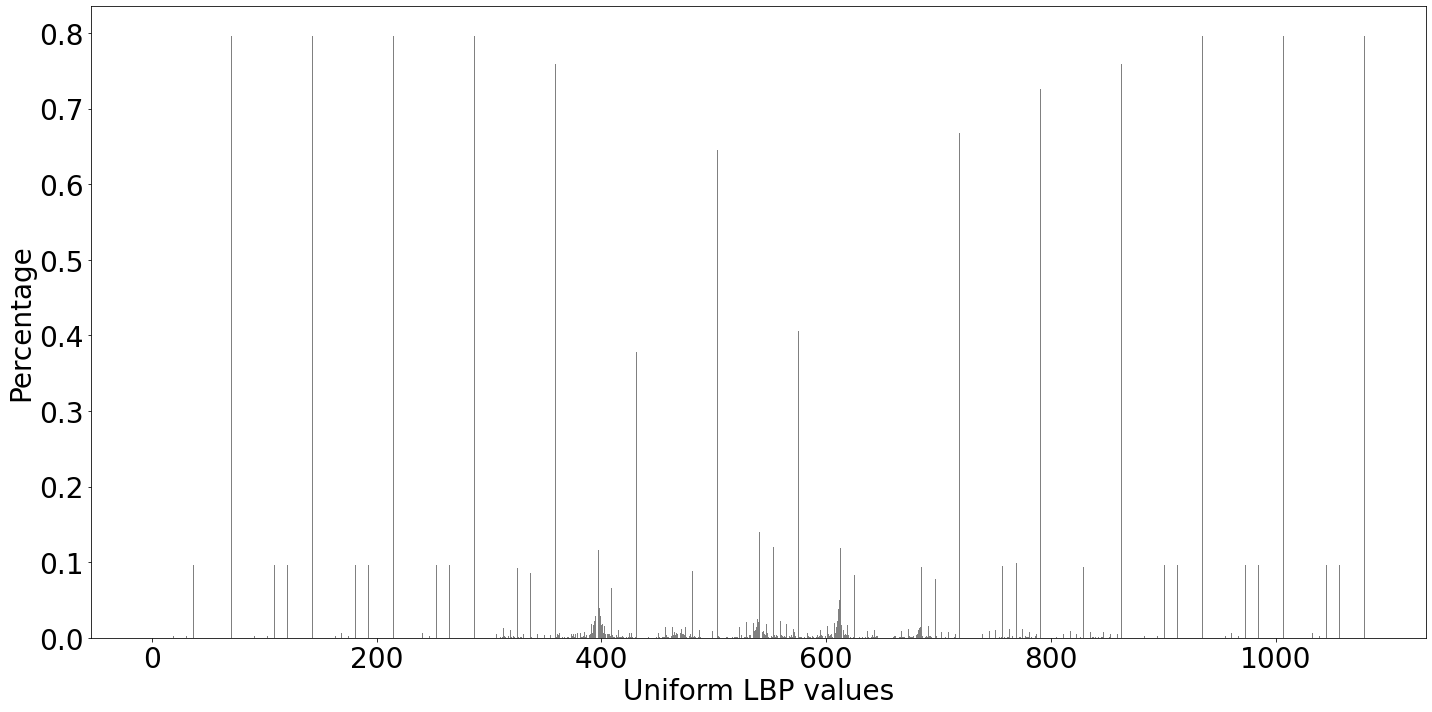

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar( np.arange(len(lbp)-72),lbp[72:], facecolor='0.5')
# ax.set_ylim(top=np.max(counts[:-1]+1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(28)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)
# plt.show()                                                             
ax.set_xlabel('Uniform LBP values', fontsize=28)
ax.set_ylabel('Percentage', fontsize=28)
# ax.hist(hist, density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

# ax.set_xlim(right=n_bins+4)
        
plt.tight_layout()
plt.show()

(14, 14, 200)

196

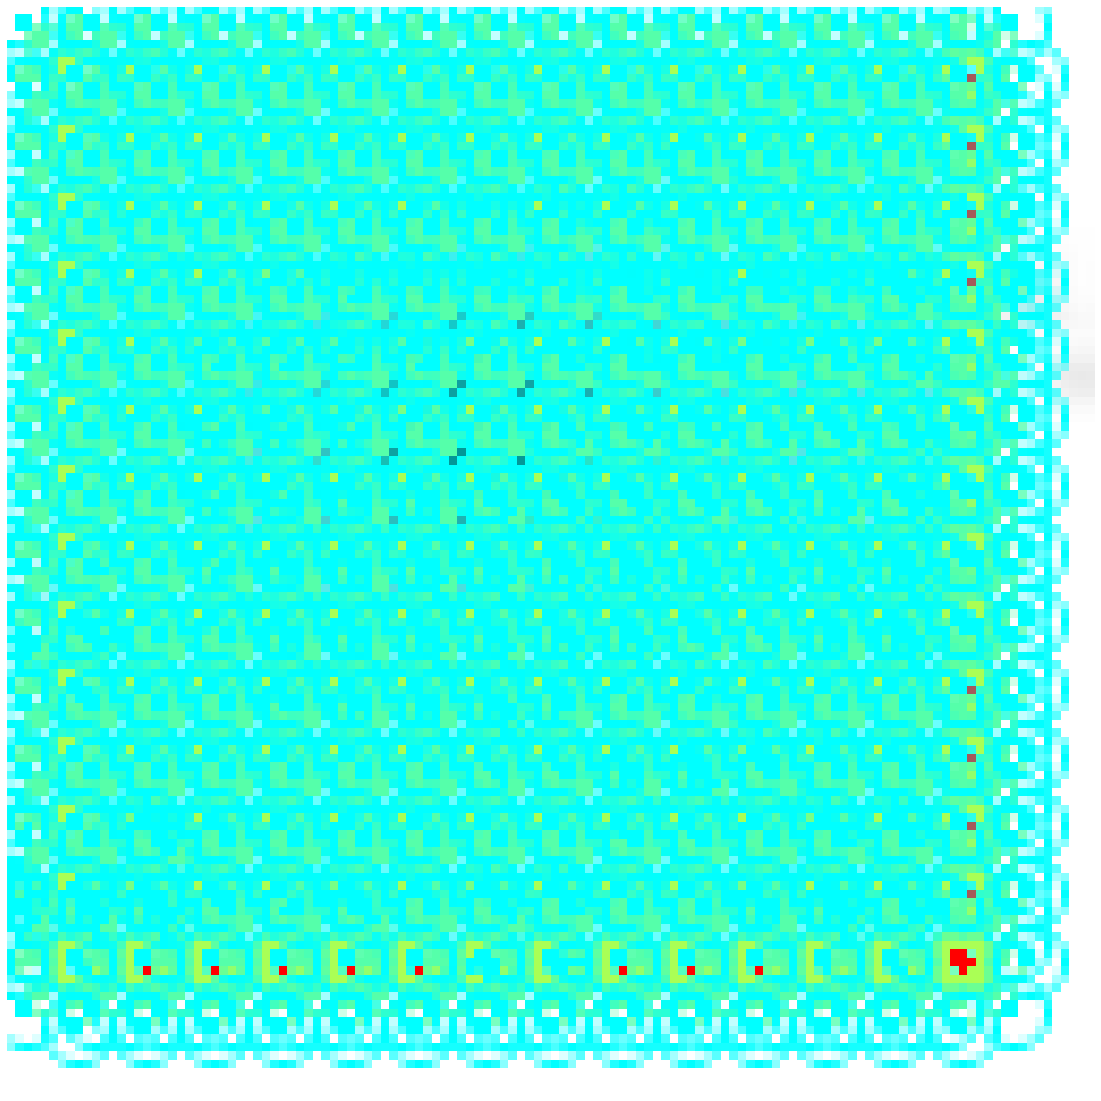

In [ ]:
img = io.imread(X_TRAINING_df["filenames"][13789])
img=rgb2gray(img)
img = skimage.transform.resize(img,(128,128))

descs_daisy, descs_img = daisy(img, step=8, radius=8, rings=3, histograms=8,orientations=8, visualize=True)

display(descs_daisy.shape)

descs_num =  descs_daisy.shape[0]*descs_daisy.shape[1]
display(descs_num)

fig, ax = plt.subplots(figsize=(20,20))
ax.axis("off")
ax.imshow(descs_img)



plt.show()


    

(14, 14, 56)

196

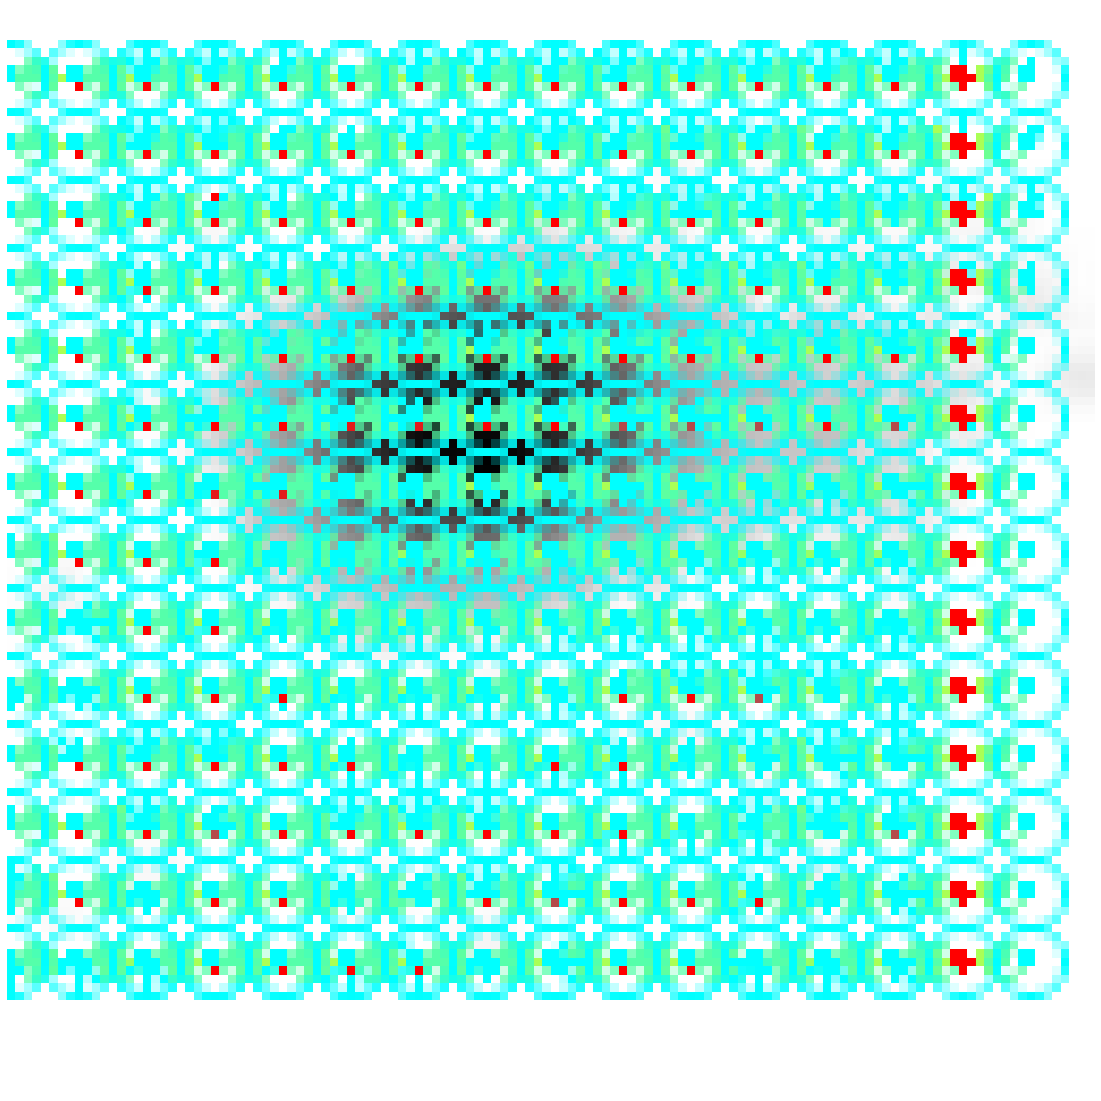

In [9]:
img = io.imread(X_TRAINING_df["filenames"][13789])
img=rgb2gray(img)
img = skimage.transform.resize(img,(128,128))

descs_daisy, descs_img = daisy(img, step=8, radius=8, rings=3, histograms=2,orientations=8, visualize=True)

display(descs_daisy.shape)

descs_num =  descs_daisy.shape[0]*descs_daisy.shape[1]
display(descs_num)

fig, ax = plt.subplots(figsize=(20,20))
ax.axis("off")
ax.imshow(descs_img)



plt.show()

In [14]:
def extract_daisy_from_image(file_path,daisy_step_size=8,daisy_radius=8):
    # Read image from file path
    img = io.imread(file_path)
    img=rgb2gray(img) # convert to grayscale image
    # img = skimage.exposure.equalize_adapthist(img, clip_limit=0.03) # adaptive image normalization cl;a
    img=resize(img,(128,128)) ##resize to a suitable dimension, avg size of images in the dataset
            
    # extract daisy feature
    descs = daisy(img, step=daisy_step_size, radius=daisy_radius, rings=3, histograms=8,orientations=8, visualize=False)
   
    # calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptors=descs.reshape(descs_num,descs.shape[2])
    
    return daisy_desriptors

def cluster_daisy_features(daisy_feature_list,number_of_clusters):
    
    km = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    
    km.fit(daisy_feature_list)
    
    return km

def extract_daisy_hog_hybrid_feature_from_image(fname,daisy_cluster_model):
    
    #incase if we have encountered the file during training, the daisy would already have been computed
    # if fname in training_data_feature_map:
    #     daisy_features=training_data_feature_map[fname][0]
    # else:
    #     print("NO")
    #     daisy_features=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
    
    daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)     
    
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector) # normalize the histogram

    return list(bovw_feature)

In [15]:
X_TRAINING_df = pd.concat([X_train_aug_df, X_train_df], ignore_index=True)

print('total files in training split:',len(X_TRAINING_df))

print('total files in testting split:',len(X_train_aug_df))

total files in training split: 264872
total files in testting split: 220773


In [ ]:
# training_data_feature_map={} ##map to store daisy feature as well as hog feature for all training datapoints
daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
counter=0
for fname in tqdm(X_train_aug_df["filenames"][1:10]):
    
    # extract DAISY features
    daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)
    
    # save in a map    
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
    

        
print('Total daisy descriptors:',len(daisy_descriptor_list))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.57it/s]

Total daisy descriptors: 1764


In [44]:
def test_sum(a,b,&c):
    c=a+b
    return c
    

SyntaxError: invalid syntax (3716284671.py, line 1)

In [42]:
c=1

test_sum(7,8,c)

display(c)

1

In [49]:
n = 3  #chunk row size
list_df = [X_train_aug_df["filenames"][1:11][i:i+n] for i in range(0,len(X_train_aug_df["filenames"][1:11]),n)]

display(list_df)

[1    ..//_inputs//_images_augmentation//train_proce...
 2    ..//_inputs//_images_augmentation//train_proce...
 3    ..//_inputs//_images_augmentation//train_proce...
 Name: filenames, dtype: object,
 4    ..//_inputs//_images_augmentation//train_proce...
 5    ..//_inputs//_images_augmentation//train_proce...
 6    ..//_inputs//_images_augmentation//train_proce...
 Name: filenames, dtype: object,
 7    ..//_inputs//_images_augmentation//train_proce...
 8    ..//_inputs//_images_augmentation//train_proce...
 9    ..//_inputs//_images_augmentation//train_proce...
 Name: filenames, dtype: object,
 10    ..//_inputs//_images_augmentation//train_proce...
 Name: filenames, dtype: object]

In [59]:
for star in np.array_split(X_train_aug_df["filenames"][0:11], 3):
    for fname in star:
        print(fname)
        print(len(star))

..//_inputs//_images_augmentation//train_processed//aggregats_debris\0001-aggregates.png_0_5140.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0002-aggregates.png_0_5505.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0002.png_0_5104.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0003-aggregates.png_0_7844.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0004-aggregates.png_0_9023.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0004.png_0_4440.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0005-aggregates.png_0_2076.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0005-aggregates_002.png_0_5439.png
4
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0005.png_0_5608.png
3
..//_inputs//_images_augmentation//train_processed//aggregats_debris\0006-aggregates.png_0_2017.png
3
..//_inpu

In [60]:
len(X_TRAINING_df["filenames"])//5120

51

In [9]:
from tqdm.notebook import tqdm

In [16]:
number_of_clusters = 512
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        


batch:   0%|          | 0/52 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5094 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

filename:   0%|          | 0/5093 [00:00<?, ?it/s]

In [17]:
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

  0%|          | 0/44099 [00:00<?, ?it/s]

In [18]:
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

  0%|          | 0/220773 [00:00<?, ?it/s]

In [19]:
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

  0%|          | 0/14700 [00:00<?, ?it/s]

In [22]:
X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))

  0%|          | 0/6907 [00:00<?, ?it/s]

In [24]:
# Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_512//X_features_test_df.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png,0.000000,0.0,0.000000,0.000000,0.021780,0.021780,0.0,0.130682,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0002-aggregates.png,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.055385,...,0.0,0.055385,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0002.png,0.000000,0.0,0.043355,0.000000,0.043355,0.000000,0.0,0.000000,0.043355,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.086711,0.086711
3,0003-aggregates.png,0.000000,0.0,0.000000,0.000000,0.000000,0.081349,0.0,0.108465,0.000000,...,0.0,0.054233,0.027116,0.0,0.0,0.0,0.054233,0.0,0.000000,0.000000
4,0004-aggregates.png,0.026316,0.0,0.000000,0.026316,0.000000,0.026316,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.026316


(44099, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001-aggregates.png_0_5140.png,0.000000,0.0,0.049207,0.0,0.0,0.024603,0.00000,0.123017,0.000000,...,0.000000,0.0,0.049207,0.0,0.0,0.0,0.024603,0.000000,0.000000,0.0
1,0002-aggregates.png_0_5505.png,0.056433,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.056433,0.0,0.000000,0.0,0.0,0.0,0.000000,0.112867,0.000000,0.0
2,0002.png_0_5104.png,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.104828,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.052414,0.052414,0.0
3,0003-aggregates.png_0_7844.png,0.000000,0.0,0.000000,0.0,0.0,0.024784,0.12392,0.594818,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.049568,0.000000,0.000000,0.0
4,0004-aggregates.png_0_9023.png,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.031814,0.031814,0.0


(220773, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0001.png,0.038866,0.038866,0.000000,0.0,0.000000,0.0,0.000000,0.038866,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038866
1,0002-aggregates_001.png,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.035267,0.070535,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.105802,0.035267,0.000000
2,0003.png,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.130558,0.000000,0.043519
3,0007-aggregates_001.png,0.000000,0.054882,0.109764,0.0,0.000000,0.0,0.054882,0.109764,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.054882,0.000000,0.000000
4,0008-aggregates_001.png,0.000000,0.000000,0.044969,0.0,0.022485,0.0,0.000000,0.224847,0.0,...,0.0,0.0,0.022485,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


(14700, 513)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,0007-aggregates_002.png,0.000000,0.047458,0.000000,0.0,0.0,0.047458,0.0,0.094916,0.000000,...,0.047458,0.047458,0.000000,0.047458,0.0,0.047458,0.000000,0.047458,0.047458,0.0
1,0009-aggregates_001.png,0.000000,0.156710,0.062684,0.0,0.0,0.000000,0.0,0.000000,0.031342,...,0.000000,0.062684,0.000000,0.031342,0.0,0.000000,0.000000,0.000000,0.062684,0.0
2,0012-aggregates_002.png,0.000000,0.000000,0.000000,0.0,0.0,0.029260,0.0,0.000000,0.029260,...,0.000000,0.029260,0.029260,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,002-aggregates_001.png,0.102869,0.051434,0.102869,0.0,0.0,0.051434,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,002-aggregates_007.png,0.000000,0.054882,0.054882,0.0,0.0,0.000000,0.0,0.109764,0.000000,...,0.000000,0.000000,0.054882,0.000000,0.0,0.000000,0.109764,0.000000,0.000000,0.0


(6907, 513)

In [25]:
import pickle

pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_512//daisy_kmeans_512.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

In [26]:
number_of_clusters = 256
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


batch:   0%|          | 0/104 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:01<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2547 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

filename:   0%|          | 0/2546 [00:00<?, ?it/s]

  0%|          | 0/44099 [00:00<?, ?it/s]

  0%|          | 0/220773 [00:00<?, ?it/s]

  0%|          | 0/14700 [00:00<?, ?it/s]

  0%|          | 0/6907 [00:00<?, ?it/s]

In [27]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_256//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_256//daisy_kmeans_256.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0001-aggregates.png,0.024544,0.000000,0.073632,0.000000,0.000000,0.024544,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.073632,0.000000,0.024544,0.000000,0.000000,0.000000,0.000000
1,0002-aggregates.png,0.000000,0.000000,0.000000,0.046829,0.046829,0.046829,0.000000,0.0,0.046829,...,0.0,0.046829,0.0,0.000000,0.046829,0.046829,0.046829,0.000000,0.046829,0.046829
2,0002.png,0.036131,0.000000,0.000000,0.000000,0.000000,0.072263,0.036131,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.072263,0.036131,0.072263,0.000000
3,0003-aggregates.png,0.000000,0.072002,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0004-aggregates.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.024708,0.000000,0.0,0.123542,...,0.0,0.074125,0.0,0.000000,0.049417,0.000000,0.049417,0.024708,0.000000,0.024708


(44099, 257)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0001-aggregates.png_0_5140.png,0.076596,0.025532,0.051064,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.051064,0.000000,0.000000,0.102129,0.000000,0.025532,0.000000,0.000000,0.000000,0.000000
1,0002-aggregates.png_0_5505.png,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.091863,0.000000,0.183726,0.137795,0.183726,0.045932
2,0002.png_0_5104.png,0.041885,0.041885,0.000000,0.083771,0.209427,0.083771,0.041885,0.000000,0.0,...,0.000000,0.041885,0.000000,0.000000,0.000000,0.000000,0.041885,0.041885,0.209427,0.041885
3,0003-aggregates.png_0_7844.png,0.000000,0.074628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.049752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0004-aggregates.png_0_9023.png,0.000000,0.000000,0.029463,0.029463,0.000000,0.058926,0.000000,0.029463,0.0,...,0.029463,0.000000,0.088388,0.000000,0.000000,0.000000,0.000000,0.029463,0.029463,0.000000


(220773, 257)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0001.png,0.0343,0.034300,0.000000,0.000000,0.0,0.000000,0.034300,0.0,0.0,...,0.0343,0.0,0.0,0.0,0.068599,0.0,0.068599,0.000000,0.000000,0.034300
1,0002-aggregates_001.png,0.0000,0.060248,0.030124,0.000000,0.0,0.000000,0.030124,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.030124,0.000000
2,0003.png,0.0000,0.000000,0.000000,0.000000,0.0,0.036131,0.036131,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.036131,0.072263,0.289052,0.000000
3,0007-aggregates_001.png,0.0000,0.000000,0.050379,0.050379,0.0,0.000000,0.050379,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.050379,0.050379,0.050379
4,0008-aggregates_001.png,0.0000,0.039904,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


(14700, 257)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0007-aggregates_002.png,0.083189,0.041595,0.000000,0.0,0.0,0.000000,0.000000,0.083189,0.0,...,0.000000,0.0,0.000000,0.083189,0.000000,0.000000,0.041595,0.0,0.041595,0.000000
1,0009-aggregates_001.png,0.000000,0.027995,0.139973,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.055989,0.0,0.083984,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0012-aggregates_002.png,0.000000,0.027037,0.027037,0.0,0.0,0.027037,0.000000,0.000000,0.0,...,0.000000,0.0,0.108148,0.081111,0.000000,0.054074,0.000000,0.0,0.027037,0.000000
3,002-aggregates_001.png,0.000000,0.088216,0.044108,0.0,0.0,0.000000,0.000000,0.132324,0.0,...,0.000000,0.0,0.088216,0.000000,0.000000,0.000000,0.176432,0.0,0.000000,0.088216
4,002-aggregates_007.png,0.096449,0.048224,0.000000,0.0,0.0,0.000000,0.048224,0.000000,0.0,...,0.048224,0.0,0.096449,0.000000,0.048224,0.000000,0.000000,0.0,0.144673,0.000000


(6907, 257)

In [28]:
number_of_clusters = 128
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


batch:   0%|          | 0/207 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1280 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

filename:   0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/44099 [00:00<?, ?it/s]

  0%|          | 0/220773 [00:00<?, ?it/s]

  0%|          | 0/14700 [00:00<?, ?it/s]

  0%|          | 0/6907 [00:00<?, ?it/s]

In [29]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_128//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_128//daisy_kmeans_128.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0001-aggregates.png,0.000000,0.000000,0.033482,0.000000,0.033482,0.000000,0.117189,0.066965,0.066965,...,0.000000,0.016741,0.050224,0.000000,0.000000,0.000000,0.000000,0.033482,0.904027,0.000000
1,0002-aggregates.png,0.186598,0.000000,0.000000,0.111959,0.223918,0.037320,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037320,0.149279,0.000000,0.111959,0.074639,0.037320,0.335877,0.037320
2,0002.png,0.062746,0.062746,0.031373,0.000000,0.031373,0.094118,0.031373,0.000000,0.000000,...,0.125491,0.000000,0.062746,0.062746,0.031373,0.031373,0.125491,0.062746,0.596083,0.000000
3,0003-aggregates.png,0.000000,0.000000,0.014822,0.000000,0.088930,0.000000,0.148217,0.014822,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.874482,0.000000
4,0004-aggregates.png,0.118846,0.023769,0.023769,0.071307,0.023769,0.000000,0.023769,0.000000,0.023769,...,0.000000,0.000000,0.000000,0.095077,0.023769,0.118846,0.047538,0.000000,0.784381,0.237691


(44099, 129)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0001-aggregates.png_0_5140.png,0.000000,0.000000,0.071842,0.000000,0.017961,0.000000,0.125724,0.017961,0.053882,...,0.000000,0.000000,0.053882,0.017961,0.017961,0.000000,0.000000,0.035921,0.898027,0.0
1,0002-aggregates.png_0_5505.png,0.112906,0.188177,0.000000,0.037635,0.037635,0.112906,0.037635,0.000000,0.000000,...,0.000000,0.000000,0.037635,0.000000,0.112906,0.225813,0.075271,0.037635,0.263448,0.0
2,0002.png_0_5104.png,0.174608,0.000000,0.034922,0.034922,0.104765,0.034922,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.069843,0.104765,0.000000,0.104765,0.174608,0.069843,0.314294,0.0
3,0003-aggregates.png_0_7844.png,0.000000,0.000000,0.015519,0.000000,0.000000,0.000000,0.062077,0.124154,0.000000,...,0.000000,0.170712,0.000000,0.000000,0.000000,0.000000,0.000000,0.015519,0.682848,0.0
4,0004-aggregates.png_0_9023.png,0.078140,0.026047,0.000000,0.000000,0.078140,0.000000,0.000000,0.000000,0.000000,...,0.130233,0.026047,0.000000,0.000000,0.026047,0.026047,0.052093,0.026047,0.703259,0.0


(220773, 129)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0001.png,0.110180,0.027545,0.000000,0.000000,0.000000,0.000000,0.027545,0.027545,0.055090,...,0.000000,0.000000,0.000000,0.055090,0.027545,0.110180,0.000000,0.000000,0.661079,0.0
1,0002-aggregates_001.png,0.090815,0.000000,0.000000,0.000000,0.181631,0.022704,0.045408,0.022704,0.000000,...,0.022704,0.090815,0.022704,0.000000,0.000000,0.204334,0.227038,0.000000,0.771930,0.0
2,0003.png,0.118056,0.000000,0.000000,0.000000,0.088542,0.029514,0.088542,0.029514,0.000000,...,0.000000,0.000000,0.088542,0.029514,0.000000,0.059028,0.354169,0.029514,0.265627,0.0
3,0007-aggregates_001.png,0.073225,0.073225,0.000000,0.036613,0.036613,0.073225,0.109838,0.036613,0.036613,...,0.000000,0.109838,0.000000,0.036613,0.000000,0.109838,0.146450,0.000000,0.475964,0.0
4,0008-aggregates_001.png,0.000000,0.015915,0.015915,0.000000,0.000000,0.000000,0.000000,0.111406,0.000000,...,0.127321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.795759,0.0


(14700, 129)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0007-aggregates_002.png,0.064416,0.032208,0.096623,0.032208,0.000000,0.000000,0.128831,0.032208,0.000000,...,0.000000,0.000000,0.032208,0.096623,0.064416,0.032208,0.193247,0.064416,0.611949,0.0
1,0009-aggregates_001.png,0.000000,0.000000,0.049118,0.024559,0.024559,0.073677,0.024559,0.049118,0.073677,...,0.000000,0.024559,0.098235,0.073677,0.024559,0.000000,0.024559,0.000000,0.884118,0.0
2,0012-aggregates_002.png,0.000000,0.000000,0.158682,0.000000,0.000000,0.000000,0.000000,0.068006,0.022669,...,0.000000,0.022669,0.090675,0.000000,0.000000,0.000000,0.022669,0.000000,0.816077,0.0
3,002-aggregates_001.png,0.030542,0.244339,0.000000,0.030542,0.061085,0.000000,0.061085,0.030542,0.000000,...,0.000000,0.030542,0.000000,0.000000,0.030542,0.000000,0.030542,0.030542,0.549762,0.0
4,002-aggregates_007.png,0.116248,0.116248,0.038749,0.038749,0.077498,0.000000,0.116248,0.116248,0.077498,...,0.038749,0.038749,0.038749,0.038749,0.038749,0.038749,0.116248,0.038749,0.309994,0.0


(6907, 129)

In [ ]:
number_of_clusters = 1024
batch_sise = number_of_clusters*10

daisy_kmeans = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=batch_sise)

number_of_batch = len(X_TRAINING_df)// batch_sise + 1

list_batches = np.array_split(X_TRAINING_df["filenames"], number_of_batch)

# for batch in tqdm(np.array_split(X_TRAINING_df["filenames"], number_of_batch), leave=False):
for batch in tqdm(list_batches, desc='batch', position=0, leave=False, colour='green'):    
    daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
    
    # for i in tqdm(range(len(batch)), desc='filename', position=1, leave=False, colour='red', ncols=80):
    for fname in tqdm(batch, desc='filename', position=1, leave=True, colour='red'):
        # extract DAISY features
        # fname = batch[i]
        daisy_features=extract_daisy_from_image(fname,daisy_step_size=8,daisy_radius=8)

        # save in a map    
        daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
        
    daisy_kmeans = daisy_kmeans.partial_fit(daisy_descriptor_list)

        
X_daisy_train=[]

for fname in tqdm(X_train_df["filenames"]):
    X_daisy_train.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_train_aug=[]

for fname in tqdm(X_train_aug_df["filenames"]):
    X_daisy_train_aug.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    
    
X_daisy_validation=[]

for fname in tqdm(X_validation_df["filenames"]):
    X_daisy_validation.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    
    

X_daisy_test=[]

for fname in tqdm(X_test_df["filenames"]):
    X_daisy_test.append(extract_daisy_hog_hybrid_feature_from_image(fname,daisy_kmeans))
    


batch:   0%|          | 0/26 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10188 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

filename:   0%|          | 0/10187 [00:00<?, ?it/s]

  0%|          | 0/44099 [00:00<?, ?it/s]

  0%|          | 0/220773 [00:00<?, ?it/s]

  0%|          | 0/14700 [00:00<?, ?it/s]

In [ ]:
##Daisy for train set
X_daisy_train_dff = pd.DataFrame(data = X_daisy_train)
X_daisy_train_df = pd.DataFrame(data = X_train_df["short_filenames"])

X_daisy_train_df = pd.concat([X_daisy_train_df,X_daisy_train_dff], axis=1)
X_daisy_train_df.columns = pd.RangeIndex(X_daisy_train_df.columns.size)

display(X_daisy_train_df.head(5), X_daisy_train_df.shape)

X_daisy_train_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_df.csv", header=False, index=False)

# Daisy for augmented train set
X_daisy_train_aug_dff = pd.DataFrame(data = X_daisy_train_aug)
X_daisy_train_aug_df = pd.DataFrame(data = X_train_aug_df["short_filenames"])

X_daisy_train_aug_df = pd.concat([X_daisy_train_aug_df,X_daisy_train_aug_dff], axis=1)
X_daisy_train_aug_df.columns = pd.RangeIndex(X_daisy_train_aug_df.columns.size)

display(X_daisy_train_aug_df.head(5), X_daisy_train_aug_df.shape)

X_daisy_train_aug_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_train_aug_df.csv", header=False, index=False)

# Daisy for validation set
X_daisy_validation_dff = pd.DataFrame(data = X_daisy_validation)
X_daisy_validation_df = pd.DataFrame(data = X_validation_df["short_filenames"])

X_daisy_validation_df = pd.concat([X_daisy_validation_df,X_daisy_validation_dff], axis=1)
X_daisy_validation_df.columns = pd.RangeIndex(X_daisy_validation_df.columns.size)

display(X_daisy_validation_df.head(5), X_daisy_validation_df.shape)

X_daisy_validation_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_validation_df.csv", header=False, index=False)

# Daisy for test set
X_daisy_test_dff = pd.DataFrame(data = X_daisy_test)
X_daisy_test_df = pd.DataFrame(data = X_test_df["short_filenames"])

X_daisy_test_df = pd.concat([X_daisy_test_df,X_daisy_test_dff], axis=1)
X_daisy_test_df.columns = pd.RangeIndex(X_daisy_test_df.columns.size)

display(X_daisy_test_df.head(5), X_daisy_test_df.shape)

X_daisy_test_df.to_csv("..//_inputs//_image_features//daisy_1024//X_features_test_df.csv", header=False, index=False)


pickle.dump(daisy_kmeans, open("..//_inputs//_image_features//daisy_1024//daisy_kmeans_1024.pkl", "wb"))


# load the model
# model = pickle.load(open("model.pkl", "rb"))